# Description
Say something here.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
# import halo_exchange
from halos_exchange import HaloExchange
from pprint import pprint
from time import perf_counter

In [28]:
! mkdir serial_steps
! mkdir parallel_steps
! mkdir serial_out
! mkdir parallel_out

mkdir: serial_steps: File exists
mkdir: parallel_steps: File exists
mkdir: serial_out: File exists
mkdir: parallel_out: File exists


# Serial Code

## Initial Condition

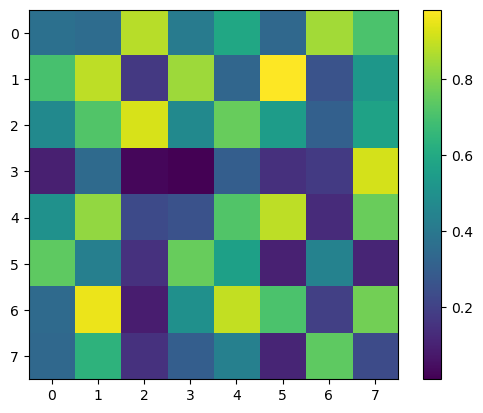

In [29]:
# a simple case with size 8,8
# mesh_2d = np.random.random((8,8))
# mesh_2d = np.random.randint(1,10,(8,8))
# pprint(mesh_2d)
# mesh_2d = np.array([[9, 6, 3, 7, 8, 8, 5, 9],
#                     [7, 8, 9, 8, 2, 2, 9, 3],
#                     [6, 3, 7, 5, 4, 5, 9, 8],
#                     [1, 5, 7, 3, 2, 8, 1, 6],
#                     [6, 2, 7, 3, 3, 5, 9, 7],
#                     [8, 8, 7, 1, 1, 4, 2, 4],
#                     [5, 2, 5, 1, 5, 1, 5, 9],
#                     [6, 4, 7, 6, 5, 1, 1, 9]])

# randomly generated initial condition
mesh_2d = np.array([[0.36957142, 0.35448541, 0.87534055, 0.41334616, 0.58921851,
                     0.33873342, 0.84686359, 0.70661254],
                    [0.70057196, 0.88576827, 0.16987487, 0.84091359, 0.33203134,
                     0.98150579, 0.25927917, 0.52427803],
                    [0.46945511, 0.71938923, 0.92161953, 0.47165736, 0.75622128,
                     0.54595177, 0.30856705, 0.56784142],
                    [0.09464055, 0.34605817, 0.02577937, 0.00983891, 0.30026129,
                     0.1449963, 0.17470095, 0.91703354],
                    [0.50243758, 0.82406356, 0.22732425, 0.25323539, 0.71764112,
                     0.88660062, 0.13041651, 0.76067969],
                    [0.74190659, 0.42878908, 0.14753486, 0.75686801, 0.56198465,
                     0.09739528, 0.44083451, 0.11082951],
                    [0.34638461, 0.95217675, 0.08757205, 0.49765066, 0.89150327,
                     0.70783763, 0.19393284, 0.77442823],
                    [0.33802426, 0.63746115, 0.14900671, 0.30016339, 0.43270171,
                     0.11015575, 0.73895399, 0.23091873]])
# pprint(mesh_2d)
plt.imshow(mesh_2d)
plt.colorbar()


## SAME padding simulation

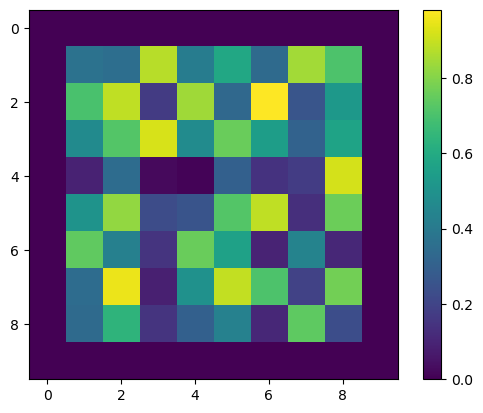

In [30]:
# set up a very simple stencil calculation
# simulate SAME padding
mesh_2d = np.pad(mesh_2d, (1, 1), 'constant', constant_values=(0,))
plt.imshow(mesh_2d)
plt.colorbar()


## Stencil computation

In [31]:
# dominant loop
mesh_2d_new = np.zeros_like(mesh_2d)
start = perf_counter()
for t in range(1000):
    np.save('serial_steps/serial_{}'.format(t), mesh_2d)
    for i in range(1, 9):
        for j in range(1, 9):
            # print(i,' ', j)
            mesh_2d_new[i][j] = mesh_2d[i][j] + (mesh_2d[i-1][j] + mesh_2d[i+1]
                                                 [j] + mesh_2d[i][j-1] + mesh_2d[i][j+1])*0.25

    # np.save('serial_steps/serial_{}'.format(t),mesh_2d_new)
    # timestepping: note that we need a new copy, not referencing the original data
    mesh_2d = np.copy(mesh_2d_new)
    # np.save('serial_steps/serial_{}'.format(t),mesh_2d)
end = perf_counter()
print("[TOTAL TIME] {}".format(end - start))


[TOTAL TIME] 0.2006775001063943


## Ground Truth

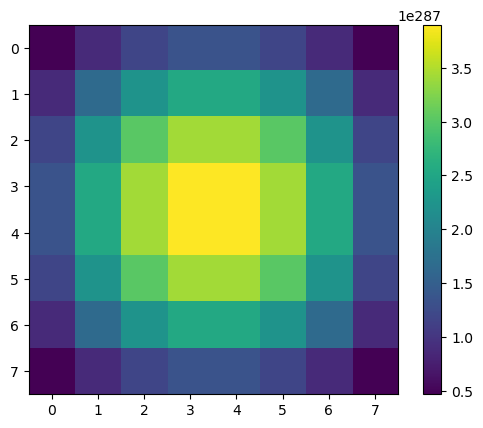

In [32]:
plt.imshow(mesh_2d[1:-1, 1:-1])
plt.colorbar()
# pprint(mesh_2d[1:-1, 1:-1])

# Parallel Code

## Code implementation

In [33]:
%%writefile decomposed_stencil.py
from halos_exchange import HaloExchange
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from time import perf_counter


mesh = np.array([[0.36957142, 0.35448541, 0.87534055, 0.41334616, 0.58921851,
                  0.33873342, 0.84686359, 0.70661254],
                 [0.70057196, 0.88576827, 0.16987487, 0.84091359, 0.33203134,
                  0.98150579, 0.25927917, 0.52427803],
                 [0.46945511, 0.71938923, 0.92161953, 0.47165736, 0.75622128,
                  0.54595177, 0.30856705, 0.56784142],
                 [0.09464055, 0.34605817, 0.02577937, 0.00983891, 0.30026129,
                  0.1449963, 0.17470095, 0.91703354],
                 [0.50243758, 0.82406356, 0.22732425, 0.25323539, 0.71764112,
                  0.88660062, 0.13041651, 0.76067969],
                 [0.74190659, 0.42878908, 0.14753486, 0.75686801, 0.56198465,
                  0.09739528, 0.44083451, 0.11082951],
                 [0.34638461, 0.95217675, 0.08757205, 0.49765066, 0.89150327,
                  0.70783763, 0.19393284, 0.77442823],
                 [0.33802426, 0.63746115, 0.14900671, 0.30016339, 0.43270171,
                  0.11015575, 0.73895399, 0.23091873]])

he = HaloExchange(structured=True, tensor_used=False,
                  double_precision=True, corner_exchanged=True)
sub_x, sub_y, current_domain = he.initialization(
    mesh, is_periodic=False, is_reordered=False)

current_domain = he.structured_halo_update_2D(current_domain)

# print(f'{sub_nx},{sub_ny}')
# pprint(current_domain)

# mesh = np.array([[9, 6, 3, 7, 8, 8, 5, 9],
#                  [7, 8, 9, 8, 2, 2, 9, 3],
#                  [6, 3, 7, 5, 4, 5, 9, 8],
#                  [1, 5, 7, 3, 2, 8, 1, 6],
#                  [6, 2, 7, 3, 3, 5, 9, 7],
#                  [8, 8, 7, 1, 1, 4, 2, 4],
#                  [5, 2, 5, 1, 5, 1, 5, 9],
#                  [6, 4, 7, 6, 5, 1, 1, 9]])


rank = he.rank
current_domain_new = np.zeros_like(current_domain)

start = perf_counter()
for t in range(1000):
    np.save('parallel_steps/parallel_{}_{}'.format(rank, t), current_domain)
    for i in range(1, sub_x+1):
        for j in range(1, sub_y+1):
            current_domain_new[i][j] = current_domain[i][j] + (current_domain[i-1][j] + current_domain[i+1]
                                                               [j] + current_domain[i][j-1] + current_domain[i][j+1])*0.25

    # np.save('parallel_steps/parallel_{}_{}'.format(rank,t),current_domain_new)
    # update the halo at each time step
    current_domain = np.copy(current_domain_new)
    current_domain = he.structured_halo_update_2D(current_domain)
    # np.save('parallel_steps/parallel_{}_{}'.format(rank,t),current_domain)


end = perf_counter()
print("[TOTAL TIME] {}".format(end - start))
np.save('parallel_out/ans_{}.npy'.format(rank), current_domain[1:-1, 1:-1])


Overwriting decomposed_stencil.py


Here you might need to run the parallelisation manually.

In [8]:
# ! rm -rf ans_* # clear the result of last run
! mpiexec -n 2 python decomposed_stencil.py # run it in parallel

## Compare result

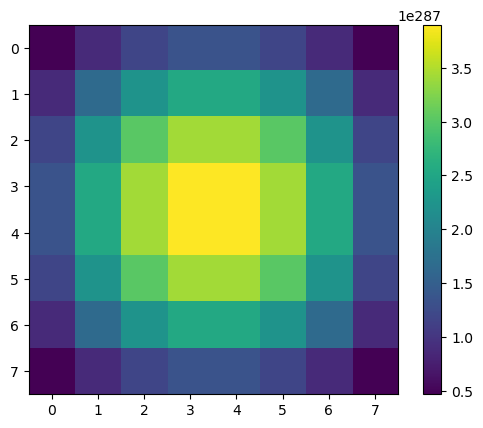

In [8]:
a1 = np.load("parallel_out/ans_0.npy")
a2 = np.load("parallel_out/ans_1.npy")
# a3 = np.load("ans_2.npy")
# a4 = np.load("ans_3.npy")

p_mesh = np.concatenate([a1, a2], axis=1)

# row1 = np.concatenate([a1,a2],axis=1)
# row2 = np.concatenate([a3,a4],axis=1)
# p_mesh = np.concatenate([row1,row2],axis=0)

plt.imshow(p_mesh)
plt.colorbar()


In [9]:
print(mesh_2d[1:-1, 1:-1])
print(p_mesh)

[[4.70302650e+286 8.83879859e+286 1.19084811e+287 1.35418251e+287
  1.35418251e+287 1.19084811e+287 8.83879859e+286 4.70302650e+286]
 [8.83879859e+286 1.66115076e+287 2.23806237e+287 2.54503062e+287
  2.54503062e+287 2.23806237e+287 1.66115076e+287 8.83879859e+286]
 [1.19084811e+287 2.23806237e+287 3.01533327e+287 3.42891048e+287
  3.42891048e+287 3.01533327e+287 2.23806237e+287 1.19084811e+287]
 [1.35418251e+287 2.54503062e+287 3.42891048e+287 3.89921313e+287
  3.89921313e+287 3.42891048e+287 2.54503062e+287 1.35418251e+287]
 [1.35418251e+287 2.54503062e+287 3.42891048e+287 3.89921313e+287
  3.89921313e+287 3.42891048e+287 2.54503062e+287 1.35418251e+287]
 [1.19084811e+287 2.23806237e+287 3.01533327e+287 3.42891048e+287
  3.42891048e+287 3.01533327e+287 2.23806237e+287 1.19084811e+287]
 [8.83879859e+286 1.66115076e+287 2.23806237e+287 2.54503062e+287
  2.54503062e+287 2.23806237e+287 1.66115076e+287 8.83879859e+286]
 [4.70302650e+286 8.83879859e+286 1.19084811e+287 1.35418251e+287
  1

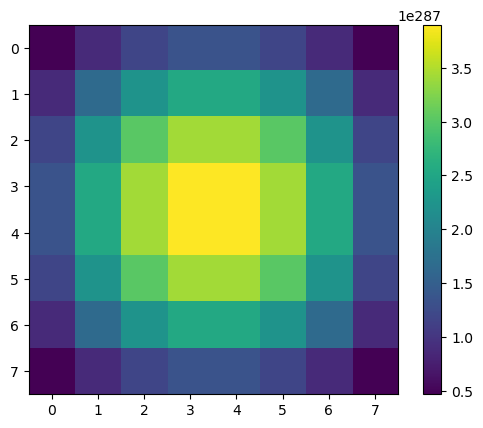

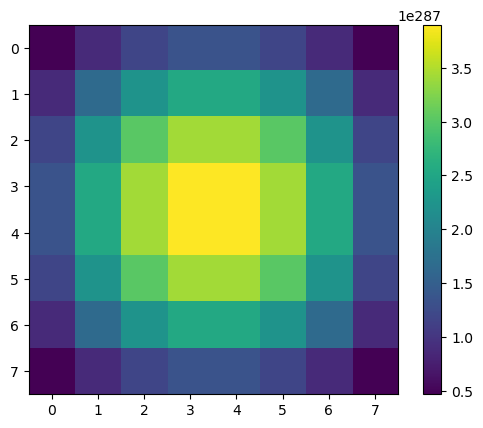

In [10]:
plt.imshow(mesh_2d[1:-1, 1:-1])
plt.colorbar()
plt.show()

plt.imshow(p_mesh)
plt.colorbar()
plt.show()


0.0
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
0.0
0.0


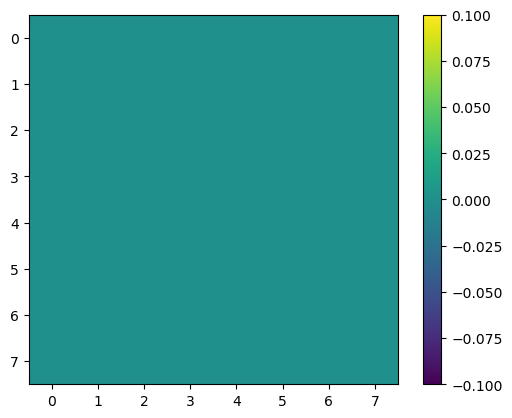

In [11]:
abe = np.abs(p_mesh - mesh_2d[1:-1, 1:-1])
plt.imshow(abe)
plt.colorbar()
print(np.sum(abe))
print(abe)
print(np.max(abe))
print(np.min(abe))
# print(np.where(abe!=0))


## Study the accuracy error

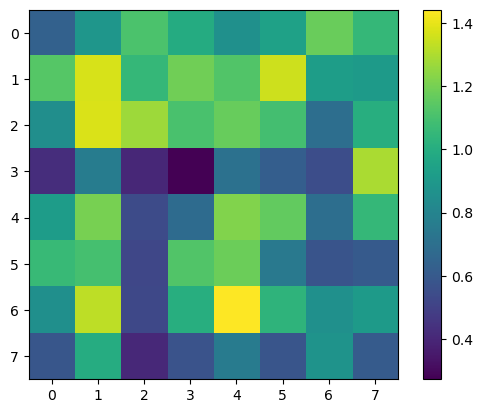

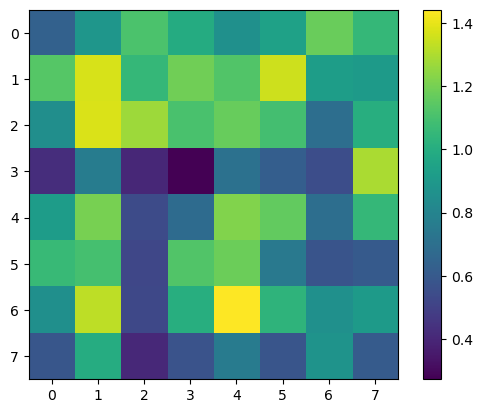

In [12]:
s1 = np.load("serial_steps/serial_1.npy")
# plt.imshow(s1)
plt.imshow(s1[1:-1, 1:-1])
plt.colorbar()
plt.show()

p_0 = np.load("parallel_steps/parallel_0_1.npy")
p_1 = np.load("parallel_steps/parallel_1_1.npy")
p_step1 = np.concatenate([p_0[1:-1, 1:-1], p_1[1:-1, 1:-1]], axis=1)
plt.imshow(p_step1)
plt.colorbar()
plt.show()


In [13]:
# pprint(s1)
pprint(s1)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.63333576, 0.88715547, 1.10976716, 0.98971432,
        0.86024624, 0.94313039, 1.17301987, 1.04939794, 0.        ],
       [0.        , 1.13177066, 1.37184864, 1.05078535, 1.18764102,
        1.12399613, 1.35050472, 0.92458279, 0.90771131, 0.        ],
       [0.        , 0.84810555, 1.3751145 , 1.26829474, 1.10380569,
        1.16869672, 1.09377437, 0.69551038, 1.00531108, 0.        ],
       [0.        , 0.42412827, 0.76202635, 0.40198959, 0.27257226,
        0.70743569, 0.62187496, 0.5499543 , 1.29283905, 0.        ],
       [0.        , 0.91759026, 1.20021583, 0.53997754, 0.68115346,
        1.21816161, 1.15921292, 0.69612045, 1.05024958, 0.        ],
       [0.        , 1.06130941, 1.09520952, 0.52267321, 1.1219694 ,
        1.17783657, 0.74670963, 0.57397805, 0.60481512, 0.        ],
       [0.        , 0.85441151, 1.3272284

In [14]:
pprint(p_0)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.63333576, 0.88715547, 1.10976716, 0.98971432,
        0.86024624],
       [0.        , 1.13177066, 1.37184864, 1.05078535, 1.18764102,
        1.12399613],
       [0.        , 0.84810555, 1.3751145 , 1.26829474, 1.10380569,
        1.16869672],
       [0.        , 0.42412827, 0.76202635, 0.40198959, 0.27257226,
        0.70743569],
       [0.        , 0.91759026, 1.20021583, 0.53997754, 0.68115346,
        1.21816161],
       [0.        , 1.06130941, 1.09520952, 0.52267321, 1.1219694 ,
        1.17783657],
       [0.        , 0.85441151, 1.32722847, 0.5241643 , 1.00667734,
        1.44154693],
       [0.        , 0.5839857 , 0.99726308, 0.40530586, 0.57000316,
        0.75815731],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])


In [15]:
pprint(p_1)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.98971432, 0.86024624, 0.94313039, 1.17301987, 1.04939794,
        0.        ],
       [1.18764102, 1.12399613, 1.35050472, 0.92458279, 0.90771131,
        0.        ],
       [1.10380569, 1.16869672, 1.09377437, 0.69551038, 1.00531108,
        0.        ],
       [0.27257226, 0.70743569, 0.62187496, 0.5499543 , 1.29283905,
        0.        ],
       [0.68115346, 1.21816161, 1.15921292, 0.69612045, 1.05024958,
        0.        ],
       [1.1219694 , 1.17783657, 0.74670963, 0.57397805, 0.60481512,
        0.        ],
       [1.00667734, 1.44154693, 1.03108442, 0.85944643, 0.9083485 ,
        0.        ],
       [0.57000316, 0.75815731, 0.58002908, 0.87270582, 0.60926428,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])


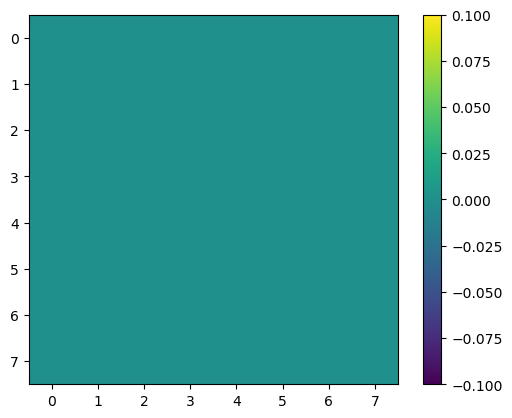

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [16]:
err = np.abs(s1[1:-1, 1:-1] - p_step1)
plt.imshow(err)
plt.colorbar()
plt.show()
print(err)

In [17]:
np.sum(err)

0.0

Here we can see that both the serial and parallel code generated the same result, correctness ensured.

# Study of stencil problem using AI libraries (Tensorflow, Pytorch etc.)

## 2D decomposed stencil problem with tensorflow

In [19]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from time import perf_counter
from mpi4py import MPI
import sys
np.set_printoptions(threshold=sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # avoid tf dnn flag issue

nx, ny = 100, 100
# mesh = np.random.randint(1,5,(nx,ny))
# mesh
problem_mesh = np.array([[4, 2, 1, 3, 2, 3, 2, 2, 3, 1, 1, 3, 1, 1, 2, 2, 3, 4, 4, 3, 2, 3,
                          4, 2, 3, 4, 4, 2, 4, 1, 4, 4, 4, 1, 2, 2, 4, 4, 4, 1, 4, 2, 4, 1,
                          3, 2, 1, 1, 2, 3, 3, 2, 2, 1, 2, 1, 2, 4, 3, 1, 3, 1, 3, 2, 3, 2,
                          2, 2, 2, 4, 4, 3, 4, 3, 1, 1, 2, 1, 3, 1, 3, 3, 3, 2, 3, 3, 4, 4,
                          3, 4, 1, 1, 4, 2, 1, 4, 3, 4, 4, 3],
                         [3, 3, 4, 2, 3, 2, 4, 3, 4, 4, 4, 2, 2, 4, 1, 1, 2, 4, 1, 4, 3, 1,
                          1, 1, 2, 3, 2, 4, 1, 3, 3, 1, 3, 2, 2, 1, 1, 1, 4, 2, 4, 4, 4, 2,
                          4, 2, 1, 1, 2, 1, 2, 1, 2, 3, 4, 1, 4, 1, 2, 3, 4, 4, 4, 3, 2, 3,
                          3, 2, 3, 3, 2, 2, 2, 3, 2, 4, 1, 3, 2, 1, 4, 3, 2, 2, 3, 2, 2, 4,
                          2, 3, 3, 4, 4, 3, 2, 3, 4, 4, 2, 3],
                         [4, 4, 4, 3, 3, 3, 4, 2, 4, 1, 4, 2, 4, 2, 2, 1, 2, 2, 2, 4, 1, 1,
                          2, 2, 1, 4, 2, 1, 3, 2, 3, 2, 2, 2, 4, 2, 2, 1, 2, 1, 4, 4, 3, 3,
                          1, 2, 2, 1, 1, 2, 2, 4, 3, 1, 3, 4, 3, 2, 4, 4, 4, 1, 1, 4, 4, 1,
                          3, 4, 3, 2, 4, 2, 2, 1, 2, 1, 1, 3, 1, 4, 1, 4, 3, 4, 3, 2, 4, 2,
                          1, 4, 2, 4, 1, 1, 3, 3, 1, 2, 2, 4],
                         [2, 2, 3, 1, 2, 4, 1, 2, 1, 2, 4, 3, 3, 2, 2, 2, 2, 4, 2, 1, 3, 2,
                          2, 3, 2, 3, 1, 2, 1, 4, 2, 1, 2, 2, 4, 1, 3, 4, 2, 3, 1, 1, 4, 1,
                          4, 2, 3, 2, 4, 4, 3, 2, 1, 3, 1, 1, 1, 1, 4, 4, 1, 3, 1, 2, 3, 1,
                          4, 3, 3, 3, 2, 3, 1, 3, 2, 2, 2, 3, 4, 3, 4, 3, 3, 4, 2, 2, 3, 3,
                          3, 1, 2, 3, 1, 1, 4, 2, 1, 2, 4, 4],
                         [2, 4, 4, 2, 1, 3, 4, 4, 1, 1, 2, 3, 3, 3, 1, 1, 2, 2, 4, 4, 4, 4,
                          4, 4, 1, 3, 4, 2, 4, 1, 2, 3, 2, 4, 3, 1, 2, 2, 1, 4, 2, 1, 1, 4,
                          3, 4, 1, 3, 2, 3, 3, 4, 1, 2, 2, 3, 4, 3, 2, 3, 3, 2, 1, 2, 4, 1,
                          4, 2, 3, 4, 3, 4, 4, 3, 1, 3, 3, 2, 2, 3, 2, 1, 2, 3, 4, 1, 4, 3,
                          2, 3, 4, 1, 1, 1, 4, 4, 1, 1, 2, 4],
                         [1, 3, 1, 1, 4, 4, 1, 3, 4, 4, 4, 4, 3, 1, 3, 1, 1, 3, 2, 1, 3, 2,
                          2, 2, 3, 1, 3, 4, 3, 4, 3, 4, 2, 2, 3, 1, 4, 3, 1, 1, 2, 4, 2, 4,
                          1, 2, 4, 1, 1, 2, 1, 3, 3, 1, 1, 2, 3, 3, 4, 4, 4, 1, 2, 3, 1, 3,
                          1, 3, 3, 3, 4, 1, 2, 2, 1, 1, 1, 2, 2, 1, 4, 1, 1, 2, 1, 2, 2, 1,
                          2, 1, 2, 2, 1, 4, 4, 2, 1, 2, 3, 3],
                         [1, 2, 4, 2, 2, 3, 1, 4, 4, 1, 4, 4, 4, 4, 4, 2, 2, 3, 1, 1, 2, 1,
                          1, 1, 4, 1, 3, 4, 3, 4, 2, 2, 4, 4, 3, 1, 3, 3, 1, 4, 2, 3, 3, 2,
                          3, 4, 1, 3, 3, 4, 4, 2, 4, 1, 1, 1, 4, 4, 2, 2, 2, 4, 1, 1, 1, 4,
                          3, 4, 3, 4, 1, 1, 4, 2, 1, 2, 3, 2, 2, 3, 2, 4, 3, 4, 4, 2, 1, 1,
                          3, 4, 1, 2, 4, 4, 1, 1, 2, 3, 2, 1],
                         [2, 2, 3, 1, 1, 2, 2, 3, 2, 4, 2, 3, 3, 3, 2, 2, 1, 3, 4, 3, 4, 4,
                          1, 1, 3, 4, 3, 4, 4, 1, 2, 1, 2, 4, 1, 4, 2, 4, 4, 1, 3, 1, 1, 4,
                          3, 2, 3, 2, 4, 1, 1, 4, 2, 1, 2, 4, 4, 3, 1, 3, 2, 3, 2, 2, 4, 1,
                          1, 2, 2, 1, 1, 4, 2, 2, 4, 3, 4, 2, 4, 4, 2, 1, 3, 4, 4, 4, 2, 4,
                          3, 3, 2, 2, 3, 3, 4, 1, 4, 4, 1, 1],
                         [2, 4, 4, 4, 1, 4, 4, 2, 2, 4, 3, 4, 4, 1, 1, 1, 2, 1, 3, 1, 4, 4,
                          2, 3, 4, 3, 4, 3, 1, 3, 2, 4, 1, 2, 3, 2, 2, 4, 4, 2, 3, 3, 1, 4,
                          4, 2, 4, 3, 3, 3, 4, 1, 1, 4, 1, 4, 2, 3, 3, 2, 3, 2, 4, 4, 3, 3,
                          1, 2, 4, 2, 1, 3, 3, 3, 1, 1, 4, 1, 3, 4, 2, 2, 3, 4, 4, 1, 4, 2,
                          1, 1, 4, 2, 3, 1, 3, 3, 1, 3, 3, 4],
                         [3, 2, 4, 1, 2, 2, 2, 3, 2, 2, 3, 3, 1, 3, 3, 2, 4, 1, 1, 1, 4, 1,
                          2, 2, 1, 1, 3, 3, 3, 1, 3, 4, 3, 4, 1, 2, 4, 2, 2, 3, 4, 2, 3, 2,
                          2, 2, 2, 2, 3, 4, 2, 1, 2, 4, 1, 3, 1, 1, 4, 1, 3, 3, 1, 3, 4, 1,
                          2, 1, 4, 4, 3, 4, 3, 3, 2, 4, 3, 4, 4, 4, 1, 2, 4, 3, 1, 4, 2, 3,
                          3, 3, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1],
                         [3, 3, 3, 2, 3, 1, 2, 3, 3, 1, 3, 4, 4, 3, 3, 3, 1, 1, 1, 3, 1, 1,
                          4, 4, 3, 4, 1, 3, 2, 4, 2, 4, 4, 2, 4, 3, 4, 2, 2, 4, 4, 4, 2, 2,
                          1, 1, 1, 3, 4, 2, 2, 4, 2, 4, 3, 1, 4, 3, 4, 3, 2, 3, 2, 3, 1, 1,
                          2, 3, 2, 3, 2, 1, 3, 1, 2, 2, 1, 4, 1, 1, 2, 1, 3, 1, 3, 1, 1, 2,
                          2, 3, 2, 4, 1, 1, 3, 3, 2, 3, 3, 1],
                         [1, 2, 4, 4, 4, 2, 1, 4, 4, 4, 4, 1, 2, 4, 3, 2, 2, 2, 2, 4, 2, 1,
                          3, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 4, 1, 3, 2, 4, 2, 2, 2, 1,
                          2, 3, 3, 2, 1, 3, 3, 2, 4, 3, 1, 3, 3, 1, 2, 2, 3, 3, 3, 3, 2, 1,
                          3, 1, 3, 3, 1, 1, 4, 1, 4, 3, 1, 4, 4, 1, 2, 2, 3, 1, 3, 4, 3, 4,
                          3, 1, 4, 2, 4, 1, 2, 1, 1, 3, 2, 3],
                         [2, 3, 2, 1, 1, 2, 2, 2, 3, 1, 1, 1, 1, 3, 3, 1, 3, 2, 3, 2, 2, 4,
                          4, 3, 4, 1, 4, 4, 4, 4, 2, 4, 4, 1, 1, 2, 2, 1, 2, 3, 4, 2, 2, 3,
                          4, 3, 2, 2, 1, 2, 1, 3, 4, 1, 1, 4, 4, 3, 1, 3, 4, 4, 1, 1, 2, 3,
                          2, 4, 4, 3, 1, 3, 2, 2, 2, 2, 4, 4, 1, 1, 1, 3, 2, 1, 3, 1, 1, 1,
                          2, 3, 2, 4, 3, 4, 4, 3, 2, 3, 4, 4],
                         [1, 1, 2, 2, 2, 4, 2, 4, 4, 4, 2, 4, 2, 3, 1, 2, 1, 2, 1, 3, 4, 2,
                          4, 4, 2, 3, 1, 3, 3, 1, 2, 4, 1, 4, 2, 3, 3, 3, 1, 3, 4, 4, 2, 3,
                          4, 2, 4, 3, 4, 3, 1, 3, 2, 3, 3, 4, 4, 2, 4, 3, 1, 4, 2, 2, 4, 3,
                          3, 3, 4, 1, 3, 2, 3, 2, 1, 3, 4, 4, 4, 3, 3, 1, 3, 3, 1, 4, 3, 4,
                          1, 2, 3, 4, 3, 1, 3, 1, 4, 4, 2, 4],
                         [1, 4, 1, 2, 3, 3, 2, 1, 1, 4, 3, 2, 1, 2, 2, 3, 2, 2, 1, 1, 1, 4,
                          1, 3, 3, 1, 1, 1, 4, 2, 2, 3, 4, 3, 4, 4, 4, 4, 3, 3, 1, 3, 2, 4,
                          1, 4, 4, 1, 4, 2, 3, 4, 4, 2, 2, 3, 1, 3, 1, 1, 2, 4, 2, 1, 3, 1,
                          3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2, 4, 4, 2, 4, 4, 3, 2, 4, 3,
                          4, 4, 1, 3, 1, 3, 3, 1, 4, 2, 2, 2],
                         [2, 1, 2, 3, 2, 2, 3, 2, 1, 4, 3, 2, 2, 1, 1, 1, 3, 1, 3, 2, 3, 3,
                          2, 1, 1, 1, 3, 3, 4, 2, 4, 3, 1, 4, 3, 4, 2, 1, 1, 1, 2, 3, 2, 4,
                          1, 4, 2, 3, 1, 2, 1, 2, 3, 3, 3, 1, 1, 2, 2, 3, 2, 1, 2, 1, 4, 2,
                          1, 3, 2, 2, 4, 3, 4, 1, 3, 4, 3, 3, 2, 3, 1, 1, 1, 4, 2, 1, 2, 2,
                          3, 2, 2, 4, 3, 2, 4, 3, 3, 4, 1, 4],
                         [3, 1, 3, 3, 2, 4, 1, 1, 4, 2, 3, 2, 1, 4, 3, 1, 2, 2, 2, 1, 3, 4,
                          2, 4, 3, 3, 1, 1, 1, 1, 4, 1, 1, 1, 2, 3, 3, 2, 1, 2, 2, 3, 3, 1,
                          2, 1, 1, 1, 4, 3, 2, 1, 1, 1, 3, 4, 4, 2, 1, 4, 4, 3, 3, 1, 2, 3,
                          2, 4, 1, 2, 2, 3, 1, 3, 2, 1, 4, 3, 1, 2, 2, 2, 4, 4, 2, 2, 2, 3,
                          1, 3, 4, 3, 2, 1, 3, 2, 1, 2, 3, 4],
                         [3, 3, 1, 3, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 4, 1, 1, 1, 4, 1, 3,
                          3, 4, 3, 1, 3, 1, 1, 4, 1, 3, 1, 3, 2, 2, 4, 3, 2, 4, 3, 1, 1, 2,
                          1, 1, 1, 1, 3, 1, 4, 2, 3, 4, 3, 1, 3, 1, 1, 3, 2, 3, 2, 1, 2, 2,
                          3, 2, 1, 4, 4, 2, 2, 3, 1, 3, 2, 4, 2, 4, 2, 3, 3, 2, 3, 1, 4, 3,
                          3, 3, 1, 3, 4, 3, 1, 2, 1, 3, 1, 4],
                         [3, 2, 4, 4, 3, 4, 2, 2, 1, 3, 2, 2, 4, 1, 2, 3, 4, 1, 4, 1, 2, 2,
                          2, 4, 1, 3, 2, 1, 4, 3, 1, 2, 4, 2, 2, 3, 1, 3, 3, 1, 3, 2, 4, 1,
                          3, 2, 4, 3, 4, 4, 4, 3, 3, 4, 4, 3, 2, 1, 4, 3, 3, 1, 2, 4, 1, 2,
                          3, 3, 4, 2, 4, 4, 2, 2, 1, 4, 1, 3, 3, 1, 1, 1, 2, 1, 1, 4, 3, 2,
                          4, 1, 1, 2, 2, 1, 3, 4, 4, 2, 2, 1],
                         [2, 3, 2, 2, 2, 1, 3, 4, 3, 2, 3, 3, 2, 1, 3, 1, 3, 4, 4, 2, 3, 3,
                          3, 1, 3, 1, 2, 2, 4, 3, 2, 4, 1, 3, 4, 2, 4, 4, 4, 3, 4, 2, 4, 4,
                          1, 4, 4, 3, 4, 2, 3, 4, 2, 3, 2, 1, 4, 4, 1, 1, 4, 2, 3, 3, 3, 1,
                          1, 2, 3, 4, 3, 2, 1, 4, 1, 2, 3, 2, 1, 4, 2, 3, 1, 3, 1, 4, 2, 4,
                          1, 4, 2, 3, 4, 2, 4, 1, 3, 4, 1, 1],
                         [2, 3, 4, 2, 4, 3, 4, 2, 4, 3, 4, 4, 2, 3, 4, 1, 3, 3, 4, 1, 1, 2,
                          2, 2, 1, 2, 3, 4, 2, 2, 2, 1, 2, 1, 2, 1, 1, 3, 4, 4, 3, 1, 4, 1,
                          3, 3, 4, 2, 3, 2, 4, 2, 1, 2, 1, 2, 2, 3, 2, 2, 1, 4, 2, 1, 4, 2,
                          1, 1, 3, 2, 1, 3, 1, 3, 2, 3, 4, 1, 3, 2, 4, 2, 3, 1, 3, 4, 4, 2,
                          2, 2, 2, 4, 4, 4, 4, 3, 2, 4, 4, 4],
                         [3, 2, 2, 4, 1, 4, 2, 1, 4, 2, 2, 3, 4, 1, 3, 4, 4, 1, 2, 2, 3, 3,
                          2, 3, 4, 2, 2, 2, 4, 1, 1, 1, 4, 3, 2, 2, 4, 3, 3, 2, 4, 1, 3, 2,
                          1, 4, 3, 1, 1, 2, 4, 1, 4, 4, 1, 4, 2, 2, 3, 4, 4, 3, 4, 3, 1, 4,
                          4, 4, 1, 1, 3, 3, 3, 2, 1, 2, 2, 2, 3, 4, 4, 1, 1, 2, 4, 4, 3, 4,
                          3, 1, 3, 1, 3, 2, 3, 1, 1, 3, 4, 2],
                         [1, 4, 2, 2, 4, 2, 2, 3, 4, 1, 3, 2, 4, 2, 1, 3, 4, 1, 4, 3, 2, 2,
                          1, 3, 3, 2, 1, 4, 2, 1, 1, 2, 4, 2, 4, 4, 2, 4, 4, 3, 1, 2, 1, 1,
                          1, 2, 4, 3, 1, 4, 3, 4, 1, 2, 4, 2, 4, 1, 3, 3, 3, 4, 2, 1, 4, 3,
                          1, 2, 4, 1, 4, 3, 4, 3, 4, 4, 4, 3, 2, 1, 1, 2, 2, 2, 4, 3, 4, 4,
                          4, 2, 4, 2, 2, 3, 1, 2, 2, 1, 4, 3],
                         [3, 2, 1, 2, 1, 4, 2, 3, 1, 2, 1, 2, 1, 2, 4, 3, 4, 1, 3, 2, 4, 2,
                          2, 3, 2, 3, 2, 1, 3, 3, 2, 4, 3, 2, 4, 1, 2, 4, 3, 1, 2, 4, 3, 1,
                          4, 1, 3, 2, 1, 3, 4, 3, 1, 1, 3, 2, 4, 3, 4, 2, 3, 3, 3, 1, 1, 4,
                          2, 2, 3, 3, 4, 4, 1, 2, 1, 3, 4, 3, 1, 4, 3, 1, 2, 1, 1, 3, 2, 3,
                          3, 4, 4, 3, 2, 3, 1, 4, 4, 3, 4, 3],
                         [1, 2, 2, 3, 2, 3, 2, 4, 4, 1, 1, 3, 4, 4, 2, 3, 1, 3, 4, 3, 4, 2,
                          2, 1, 3, 2, 2, 4, 1, 3, 3, 3, 3, 3, 4, 2, 1, 4, 1, 1, 3, 1, 1, 2,
                          4, 4, 1, 2, 4, 2, 1, 1, 4, 1, 3, 1, 2, 4, 4, 1, 4, 2, 2, 3, 2, 2,
                          3, 1, 3, 1, 3, 3, 2, 4, 3, 3, 2, 2, 2, 2, 1, 3, 2, 2, 4, 2, 4, 1,
                          2, 1, 2, 4, 4, 2, 3, 4, 4, 1, 3, 4],
                         [1, 2, 2, 1, 4, 1, 2, 2, 1, 2, 1, 1, 4, 4, 2, 4, 3, 4, 3, 3, 3, 4,
                          2, 1, 1, 1, 2, 4, 4, 2, 2, 3, 4, 4, 1, 4, 1, 4, 1, 4, 1, 1, 2, 2,
                          1, 3, 4, 1, 1, 3, 4, 3, 3, 1, 4, 2, 4, 3, 2, 4, 1, 1, 2, 1, 3, 1,
                          3, 2, 1, 2, 4, 1, 3, 2, 2, 1, 2, 2, 3, 1, 4, 2, 4, 1, 4, 4, 4, 3,
                          1, 3, 3, 4, 4, 1, 4, 4, 2, 4, 4, 1],
                         [1, 2, 1, 3, 4, 1, 4, 2, 1, 1, 3, 3, 2, 3, 3, 2, 1, 4, 3, 3, 3, 3,
                          4, 1, 1, 2, 3, 3, 4, 1, 1, 1, 2, 3, 3, 4, 2, 4, 1, 1, 1, 1, 2, 2,
                          2, 2, 2, 1, 1, 1, 2, 1, 2, 4, 1, 3, 4, 1, 3, 1, 1, 4, 3, 2, 4, 4,
                          2, 2, 2, 4, 4, 1, 1, 4, 3, 2, 2, 4, 3, 1, 2, 4, 4, 3, 3, 4, 4, 3,
                          3, 4, 1, 4, 3, 1, 3, 4, 3, 4, 4, 1],
                         [3, 1, 2, 1, 3, 3, 3, 1, 2, 2, 3, 1, 3, 2, 1, 1, 2, 2, 3, 4, 2, 2,
                          3, 3, 3, 3, 2, 4, 4, 1, 3, 3, 1, 1, 4, 3, 4, 1, 4, 4, 2, 1, 2, 1,
                          2, 1, 1, 2, 1, 2, 4, 1, 3, 4, 1, 4, 1, 3, 4, 2, 1, 3, 1, 3, 4, 4,
                          4, 1, 3, 1, 3, 3, 1, 4, 1, 3, 3, 4, 1, 1, 3, 3, 2, 2, 3, 4, 4, 1,
                          1, 2, 4, 4, 1, 2, 3, 4, 1, 2, 3, 3],
                         [2, 4, 2, 1, 2, 2, 3, 1, 3, 4, 4, 2, 1, 2, 3, 3, 2, 2, 2, 2, 2, 1,
                          4, 2, 1, 1, 1, 1, 3, 3, 3, 2, 4, 4, 1, 1, 4, 3, 3, 1, 2, 2, 4, 1,
                          3, 3, 4, 2, 1, 1, 2, 4, 4, 2, 3, 3, 1, 1, 1, 4, 3, 3, 4, 2, 3, 1,
                          3, 2, 2, 3, 2, 1, 1, 4, 3, 2, 4, 2, 1, 2, 3, 1, 3, 3, 4, 2, 2, 1,
                          1, 4, 1, 3, 2, 3, 4, 1, 4, 1, 3, 3],
                         [1, 2, 3, 2, 2, 1, 3, 3, 1, 2, 3, 4, 2, 1, 2, 4, 3, 2, 3, 2, 3, 4,
                          3, 4, 4, 2, 4, 4, 3, 3, 4, 1, 4, 1, 4, 4, 3, 4, 2, 3, 4, 2, 4, 2,
                          2, 3, 2, 1, 3, 3, 3, 3, 1, 1, 1, 2, 1, 1, 1, 3, 1, 2, 4, 3, 1, 3,
                          1, 4, 1, 2, 1, 1, 1, 1, 1, 3, 4, 4, 2, 3, 4, 4, 3, 4, 2, 1, 4, 4,
                          1, 3, 2, 1, 1, 1, 4, 3, 1, 1, 3, 4],
                         [3, 4, 2, 2, 1, 3, 4, 2, 3, 2, 4, 2, 4, 2, 1, 3, 3, 1, 3, 1, 1, 3,
                          4, 1, 2, 4, 2, 3, 2, 2, 4, 4, 2, 2, 2, 4, 3, 2, 3, 3, 2, 2, 4, 1,
                          3, 4, 2, 1, 3, 1, 3, 4, 1, 2, 4, 1, 4, 2, 2, 2, 3, 3, 2, 4, 2, 4,
                          1, 2, 2, 1, 2, 4, 4, 2, 1, 4, 1, 1, 1, 3, 2, 1, 1, 1, 3, 4, 2, 1,
                          4, 2, 1, 1, 3, 1, 1, 1, 1, 4, 3, 1],
                         [2, 2, 4, 4, 3, 4, 1, 4, 4, 1, 2, 2, 2, 1, 3, 2, 3, 2, 1, 2, 3, 1,
                          2, 2, 2, 1, 4, 1, 2, 1, 3, 3, 3, 3, 3, 4, 4, 3, 1, 4, 3, 2, 1, 4,
                          1, 3, 3, 1, 4, 2, 3, 1, 2, 1, 4, 1, 1, 1, 4, 2, 4, 1, 1, 2, 2, 4,
                          3, 3, 1, 4, 4, 3, 1, 3, 1, 3, 3, 1, 2, 1, 3, 4, 1, 2, 3, 4, 4, 4,
                          3, 1, 1, 3, 2, 4, 2, 1, 2, 1, 1, 4],
                         [2, 3, 2, 3, 2, 4, 2, 2, 3, 4, 2, 1, 2, 1, 4, 2, 1, 2, 2, 1, 2, 1,
                          4, 1, 3, 3, 3, 2, 4, 1, 1, 1, 1, 3, 3, 2, 2, 3, 1, 4, 4, 4, 4, 3,
                          2, 4, 1, 2, 1, 1, 2, 3, 4, 4, 1, 2, 4, 4, 2, 2, 3, 2, 1, 3, 1, 3,
                          3, 4, 2, 2, 4, 4, 4, 1, 4, 4, 2, 4, 4, 2, 2, 2, 2, 1, 1, 2, 2, 4,
                          2, 3, 2, 2, 4, 4, 4, 2, 3, 2, 2, 2],
                         [2, 4, 2, 3, 4, 3, 2, 3, 3, 2, 2, 1, 3, 1, 4, 4, 4, 4, 2, 2, 3, 4,
                          3, 1, 4, 4, 3, 1, 1, 2, 3, 1, 2, 2, 1, 2, 3, 4, 1, 3, 1, 3, 4, 4,
                          3, 4, 1, 2, 4, 3, 1, 2, 2, 4, 2, 3, 3, 3, 2, 2, 3, 1, 3, 2, 3, 2,
                          4, 2, 1, 3, 2, 1, 4, 4, 1, 2, 2, 2, 1, 4, 3, 3, 4, 1, 4, 2, 3, 2,
                          2, 2, 2, 4, 1, 3, 4, 1, 3, 2, 2, 1],
                         [1, 2, 1, 3, 1, 1, 4, 1, 3, 1, 2, 3, 4, 4, 2, 4, 2, 4, 2, 4, 1, 1,
                          3, 4, 4, 2, 3, 2, 4, 4, 3, 4, 3, 4, 3, 4, 4, 2, 2, 4, 4, 3, 1, 3,
                          1, 4, 4, 2, 1, 1, 4, 1, 2, 2, 3, 1, 4, 2, 3, 1, 4, 3, 2, 1, 1, 3,
                          1, 1, 3, 2, 4, 3, 2, 4, 2, 1, 3, 3, 3, 4, 1, 2, 4, 3, 2, 1, 1, 1,
                          2, 4, 1, 4, 1, 1, 1, 4, 4, 1, 2, 3],
                         [3, 4, 1, 2, 1, 3, 1, 4, 4, 3, 4, 4, 2, 2, 4, 2, 4, 4, 1, 2, 4, 1,
                          3, 1, 4, 3, 4, 1, 3, 3, 4, 3, 4, 1, 2, 3, 4, 3, 2, 1, 1, 1, 1, 1,
                          1, 3, 2, 4, 1, 4, 2, 4, 3, 1, 1, 3, 4, 1, 1, 3, 3, 4, 4, 3, 1, 3,
                          2, 4, 1, 4, 2, 1, 3, 3, 2, 2, 1, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 4,
                          2, 1, 4, 2, 4, 2, 4, 4, 3, 1, 4, 1],
                         [3, 1, 4, 4, 1, 2, 1, 3, 1, 3, 2, 1, 2, 4, 4, 4, 3, 2, 3, 2, 2, 2,
                          1, 1, 1, 2, 2, 1, 4, 3, 3, 2, 4, 3, 1, 3, 4, 3, 3, 2, 1, 1, 1, 2,
                          4, 3, 1, 1, 2, 2, 3, 3, 1, 1, 3, 3, 1, 1, 4, 1, 1, 3, 1, 2, 2, 3,
                          1, 3, 1, 3, 2, 1, 4, 1, 1, 3, 2, 2, 2, 4, 1, 3, 1, 3, 2, 3, 1, 2,
                          1, 3, 4, 1, 1, 2, 4, 4, 2, 3, 2, 4],
                         [1, 1, 4, 1, 4, 4, 1, 2, 1, 2, 2, 3, 2, 3, 4, 3, 4, 4, 4, 3, 3, 1,
                          4, 3, 1, 2, 3, 1, 3, 1, 4, 3, 3, 4, 3, 3, 3, 1, 2, 1, 4, 4, 2, 2,
                          4, 2, 2, 4, 1, 1, 1, 2, 4, 4, 2, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 2,
                          4, 2, 1, 1, 1, 3, 2, 4, 1, 3, 3, 3, 2, 2, 4, 1, 3, 1, 1, 1, 1, 3,
                          3, 2, 2, 2, 4, 2, 3, 3, 1, 2, 2, 2],
                         [3, 3, 1, 1, 2, 1, 4, 1, 2, 1, 4, 1, 3, 2, 1, 1, 4, 2, 2, 1, 3, 4,
                          2, 4, 3, 2, 4, 4, 2, 4, 1, 2, 2, 1, 4, 3, 1, 1, 1, 2, 2, 1, 4, 4,
                          4, 3, 3, 1, 3, 4, 4, 3, 3, 1, 4, 2, 3, 3, 1, 3, 2, 1, 4, 2, 1, 2,
                          2, 1, 4, 4, 1, 1, 1, 1, 4, 4, 3, 1, 1, 4, 3, 4, 3, 4, 2, 3, 1, 4,
                          1, 4, 1, 4, 4, 2, 2, 4, 4, 4, 4, 4],
                         [1, 3, 1, 2, 4, 2, 4, 3, 3, 4, 1, 3, 3, 4, 2, 2, 2, 4, 1, 4, 1, 3,
                          4, 4, 2, 3, 2, 3, 3, 2, 1, 1, 4, 4, 2, 1, 4, 4, 3, 3, 3, 3, 1, 1,
                          4, 1, 1, 4, 2, 4, 3, 2, 4, 3, 4, 3, 3, 4, 3, 1, 3, 3, 1, 3, 1, 1,
                          1, 2, 4, 2, 3, 2, 4, 3, 2, 4, 3, 4, 3, 2, 4, 2, 2, 4, 3, 4, 3, 4,
                          4, 4, 1, 2, 2, 2, 4, 3, 2, 4, 4, 3],
                         [4, 3, 3, 1, 3, 3, 1, 4, 2, 1, 4, 1, 3, 1, 1, 1, 1, 4, 2, 4, 4, 1,
                          1, 3, 4, 4, 3, 4, 4, 3, 4, 2, 4, 2, 4, 3, 2, 3, 3, 3, 4, 3, 4, 1,
                          3, 2, 2, 3, 2, 2, 2, 4, 4, 2, 1, 3, 4, 4, 3, 2, 3, 2, 3, 3, 4, 4,
                          2, 2, 3, 3, 1, 2, 1, 1, 1, 3, 3, 3, 2, 2, 3, 2, 3, 3, 1, 3, 3, 1,
                          2, 2, 3, 1, 1, 1, 2, 3, 2, 2, 2, 3],
                         [3, 4, 4, 2, 2, 2, 1, 2, 4, 1, 3, 4, 4, 2, 2, 2, 4, 4, 3, 1, 1, 2,
                          1, 2, 3, 4, 1, 4, 4, 2, 4, 4, 3, 4, 3, 2, 1, 2, 2, 2, 2, 2, 4, 4,
                          2, 2, 1, 2, 3, 2, 3, 3, 1, 2, 3, 1, 3, 2, 2, 2, 4, 1, 4, 4, 3, 2,
                          3, 4, 1, 1, 3, 4, 1, 1, 4, 2, 4, 1, 4, 2, 4, 1, 3, 4, 2, 1, 1, 4,
                          2, 4, 4, 4, 4, 3, 1, 2, 3, 3, 1, 2],
                         [1, 2, 4, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 4, 2, 4, 2,
                          2, 1, 1, 4, 2, 2, 2, 2, 1, 2, 4, 1, 1, 1, 3, 4, 4, 3, 1, 4, 2, 3,
                          1, 4, 4, 1, 2, 3, 1, 1, 2, 4, 4, 4, 4, 3, 4, 1, 1, 2, 3, 4, 2, 2,
                          2, 2, 4, 3, 1, 3, 4, 3, 3, 1, 4, 2, 3, 2, 1, 2, 2, 4, 1, 2, 3, 1,
                          3, 3, 1, 1, 2, 2, 2, 1, 2, 3, 1, 4],
                         [3, 3, 4, 4, 3, 2, 4, 1, 1, 4, 1, 2, 3, 4, 3, 3, 3, 1, 3, 3, 2, 4,
                          4, 3, 3, 1, 1, 2, 1, 1, 2, 3, 2, 1, 2, 1, 3, 4, 2, 2, 3, 1, 2, 1,
                          3, 4, 1, 3, 4, 2, 2, 2, 2, 2, 3, 4, 3, 3, 1, 1, 2, 2, 4, 1, 4, 3,
                          4, 2, 1, 4, 3, 1, 3, 4, 3, 1, 4, 3, 2, 2, 1, 2, 1, 3, 3, 4, 2, 2,
                          4, 2, 4, 1, 1, 2, 1, 2, 2, 3, 1, 3],
                         [1, 3, 2, 1, 1, 3, 3, 4, 1, 4, 2, 1, 1, 4, 3, 2, 4, 3, 1, 3, 3, 4,
                          3, 3, 1, 4, 2, 3, 2, 4, 4, 1, 4, 1, 1, 4, 3, 4, 3, 4, 2, 3, 3, 4,
                          4, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 4, 3, 1, 3, 1, 2, 3, 3, 2, 4, 2,
                          1, 4, 2, 2, 4, 4, 3, 2, 4, 1, 3, 4, 2, 3, 4, 3, 2, 4, 2, 4, 3, 1,
                          1, 1, 3, 2, 2, 2, 1, 2, 4, 3, 3, 4],
                         [1, 1, 4, 2, 1, 2, 3, 1, 4, 2, 4, 1, 3, 1, 1, 2, 4, 3, 4, 4, 3, 3,
                          3, 2, 2, 4, 2, 2, 2, 4, 2, 1, 1, 2, 4, 1, 4, 1, 4, 2, 3, 1, 2, 2,
                          1, 2, 3, 1, 2, 3, 2, 1, 3, 3, 4, 3, 1, 3, 1, 3, 1, 3, 2, 1, 4, 3,
                          1, 1, 1, 1, 4, 3, 2, 2, 2, 2, 4, 4, 3, 1, 2, 4, 1, 4, 4, 1, 4, 3,
                          4, 4, 2, 1, 2, 4, 2, 2, 3, 4, 3, 3],
                         [3, 3, 4, 3, 4, 4, 4, 2, 3, 1, 3, 2, 3, 1, 2, 3, 3, 2, 2, 2, 4, 4,
                          2, 3, 2, 3, 1, 1, 3, 4, 3, 2, 3, 4, 1, 1, 4, 3, 4, 4, 1, 2, 1, 1,
                          4, 4, 4, 2, 3, 2, 4, 4, 1, 1, 2, 2, 3, 2, 1, 1, 4, 3, 3, 3, 4, 3,
                          3, 3, 2, 2, 4, 2, 3, 3, 2, 3, 4, 2, 4, 1, 1, 1, 4, 4, 3, 2, 3, 3,
                          3, 1, 3, 2, 4, 1, 2, 1, 3, 1, 3, 3],
                         [3, 3, 2, 3, 3, 2, 4, 4, 3, 4, 3, 3, 3, 4, 3, 1, 2, 3, 3, 4, 3, 1,
                          2, 2, 1, 2, 2, 4, 1, 4, 2, 3, 3, 2, 4, 1, 1, 1, 2, 4, 1, 3, 4, 1,
                          1, 4, 4, 4, 1, 4, 2, 3, 3, 2, 3, 3, 2, 1, 4, 2, 1, 3, 4, 3, 4, 2,
                          3, 1, 4, 3, 3, 2, 2, 4, 1, 2, 2, 1, 4, 4, 4, 2, 2, 2, 2, 1, 2, 4,
                          4, 4, 3, 2, 3, 2, 3, 4, 2, 4, 1, 3],
                         [1, 4, 2, 3, 3, 1, 3, 4, 4, 1, 3, 4, 3, 2, 1, 3, 2, 1, 1, 4, 1, 3,
                          4, 2, 4, 1, 1, 3, 2, 2, 3, 1, 2, 2, 3, 4, 3, 4, 4, 3, 1, 4, 2, 4,
                          1, 1, 3, 3, 1, 4, 1, 1, 2, 3, 2, 3, 1, 2, 4, 1, 1, 3, 3, 3, 2, 4,
                          4, 4, 3, 2, 4, 4, 3, 3, 2, 3, 4, 3, 3, 1, 1, 3, 4, 4, 1, 3, 1, 2,
                          4, 3, 2, 4, 4, 3, 3, 4, 2, 1, 3, 4],
                         [1, 4, 3, 1, 1, 3, 3, 3, 3, 4, 3, 4, 4, 1, 3, 4, 1, 3, 1, 1, 4, 2,
                          4, 2, 4, 2, 2, 3, 3, 3, 3, 2, 1, 3, 3, 1, 1, 4, 1, 4, 1, 4, 3, 1,
                          4, 1, 1, 3, 3, 2, 1, 1, 4, 4, 3, 2, 1, 2, 4, 4, 2, 3, 2, 4, 4, 1,
                          2, 2, 3, 1, 3, 2, 4, 2, 4, 4, 2, 3, 4, 4, 4, 4, 2, 3, 1, 1, 2, 1,
                          2, 2, 2, 3, 4, 4, 4, 4, 4, 2, 2, 4],
                         [1, 1, 1, 2, 1, 1, 4, 3, 2, 1, 2, 3, 4, 4, 4, 2, 3, 3, 1, 2, 3, 4,
                          1, 3, 3, 2, 3, 3, 3, 1, 2, 1, 3, 1, 4, 4, 3, 3, 3, 4, 1, 4, 1, 1,
                          4, 2, 4, 2, 3, 3, 2, 3, 3, 2, 3, 2, 4, 4, 4, 1, 1, 2, 1, 1, 4, 4,
                          3, 3, 4, 1, 3, 4, 1, 4, 4, 2, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 4, 4,
                          4, 4, 2, 2, 1, 2, 1, 3, 2, 1, 1, 3],
                         [1, 3, 4, 1, 2, 3, 2, 3, 4, 4, 2, 3, 3, 1, 2, 4, 3, 4, 3, 1, 3, 3,
                          3, 1, 4, 2, 2, 1, 3, 4, 3, 4, 1, 3, 4, 4, 3, 2, 1, 1, 2, 3, 1, 3,
                          4, 4, 4, 1, 3, 1, 3, 3, 3, 1, 4, 2, 2, 4, 4, 4, 1, 2, 2, 4, 4, 1,
                          3, 4, 2, 4, 2, 1, 4, 2, 1, 2, 4, 2, 2, 4, 2, 3, 1, 1, 1, 1, 2, 4,
                          2, 2, 4, 4, 2, 4, 2, 3, 4, 2, 2, 2],
                         [3, 2, 2, 2, 4, 3, 2, 2, 4, 1, 2, 4, 2, 3, 2, 3, 2, 1, 2, 2, 4, 2,
                          2, 4, 4, 1, 3, 2, 2, 4, 4, 1, 2, 2, 4, 2, 1, 4, 1, 1, 3, 4, 1, 2,
                          3, 1, 2, 3, 2, 3, 4, 4, 4, 3, 1, 2, 3, 2, 1, 4, 1, 2, 3, 4, 3, 1,
                          1, 3, 2, 4, 1, 4, 2, 1, 1, 3, 2, 4, 1, 3, 3, 1, 3, 1, 2, 1, 4, 2,
                          1, 1, 1, 1, 2, 3, 4, 3, 2, 4, 4, 1],
                         [1, 1, 1, 1, 1, 1, 4, 3, 1, 4, 4, 4, 2, 2, 4, 2, 2, 3, 1, 3, 2, 3,
                          1, 3, 4, 4, 3, 2, 2, 1, 2, 4, 1, 1, 1, 3, 3, 1, 3, 1, 4, 2, 4, 2,
                          4, 4, 1, 2, 1, 2, 2, 4, 3, 4, 1, 3, 3, 1, 4, 2, 1, 1, 1, 3, 4, 2,
                          4, 3, 1, 4, 3, 4, 3, 2, 3, 3, 2, 1, 3, 2, 3, 1, 2, 4, 4, 3, 2, 3,
                          1, 4, 2, 3, 1, 1, 2, 1, 2, 2, 3, 2],
                         [2, 4, 3, 2, 2, 1, 1, 2, 3, 4, 2, 3, 1, 4, 3, 3, 1, 2, 2, 1, 4, 2,
                          4, 1, 4, 3, 3, 2, 3, 2, 2, 3, 3, 4, 4, 4, 1, 3, 2, 2, 3, 2, 1, 4,
                          4, 3, 2, 2, 3, 1, 4, 3, 4, 4, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 4, 1,
                          1, 1, 3, 1, 4, 4, 3, 4, 1, 1, 2, 2, 4, 2, 2, 4, 1, 2, 1, 2, 4, 4,
                          2, 1, 4, 4, 1, 1, 3, 1, 1, 2, 1, 3],
                         [3, 1, 2, 3, 2, 3, 4, 4, 4, 1, 3, 1, 1, 2, 2, 1, 2, 4, 2, 3, 2, 3,
                          4, 1, 3, 3, 3, 1, 2, 3, 1, 2, 4, 1, 3, 4, 2, 2, 4, 3, 4, 3, 3, 4,
                          3, 4, 4, 4, 3, 3, 4, 1, 3, 3, 2, 1, 3, 3, 3, 3, 1, 2, 2, 1, 2, 2,
                          4, 3, 3, 3, 4, 3, 1, 4, 4, 3, 2, 4, 2, 1, 2, 2, 3, 4, 4, 1, 3, 4,
                          1, 4, 3, 3, 4, 2, 4, 2, 1, 2, 1, 2],
                         [2, 1, 4, 2, 2, 1, 1, 4, 3, 2, 3, 4, 3, 4, 4, 3, 4, 1, 1, 1, 1, 1,
                          4, 1, 1, 4, 1, 4, 2, 4, 1, 3, 1, 3, 1, 4, 4, 1, 2, 3, 3, 1, 2, 4,
                          4, 4, 4, 1, 4, 3, 3, 1, 4, 1, 4, 2, 3, 3, 4, 4, 3, 4, 4, 1, 3, 3,
                          4, 4, 3, 2, 1, 4, 2, 1, 2, 1, 1, 2, 4, 4, 2, 3, 3, 1, 4, 4, 3, 1,
                          4, 3, 1, 4, 1, 3, 3, 2, 1, 1, 3, 2],
                         [2, 1, 3, 4, 4, 4, 4, 4, 1, 2, 1, 2, 4, 2, 1, 2, 4, 2, 4, 1, 4, 4,
                          2, 1, 1, 1, 1, 2, 4, 1, 3, 2, 1, 4, 3, 1, 4, 2, 1, 3, 3, 2, 3, 4,
                          1, 1, 4, 1, 4, 2, 3, 2, 4, 1, 2, 1, 2, 1, 4, 2, 1, 2, 3, 4, 1, 3,
                          3, 4, 1, 4, 2, 2, 3, 4, 2, 4, 3, 2, 2, 3, 3, 3, 4, 2, 4, 3, 4, 1,
                          3, 1, 4, 3, 1, 3, 2, 2, 1, 1, 3, 2],
                         [2, 2, 4, 4, 1, 2, 4, 4, 2, 1, 3, 2, 2, 4, 3, 1, 3, 3, 4, 3, 1, 3,
                          2, 1, 3, 1, 1, 3, 3, 3, 2, 4, 1, 2, 2, 3, 3, 3, 4, 3, 3, 3, 2, 4,
                          4, 1, 3, 1, 2, 4, 1, 3, 3, 3, 4, 4, 3, 3, 1, 2, 2, 2, 4, 1, 2, 2,
                          2, 2, 1, 3, 4, 1, 3, 2, 1, 2, 1, 1, 4, 3, 2, 3, 2, 4, 1, 4, 3, 2,
                          4, 3, 4, 3, 3, 1, 4, 4, 3, 1, 2, 3],
                         [3, 4, 3, 1, 3, 1, 3, 4, 4, 4, 3, 1, 1, 1, 3, 4, 3, 1, 1, 2, 2, 1,
                          1, 2, 4, 2, 1, 2, 1, 2, 3, 1, 4, 1, 2, 4, 3, 4, 2, 3, 2, 3, 2, 1,
                          4, 3, 2, 4, 1, 3, 1, 4, 4, 1, 4, 2, 4, 1, 2, 2, 4, 2, 2, 3, 2, 1,
                          1, 1, 1, 4, 1, 1, 2, 2, 1, 1, 4, 2, 3, 1, 3, 2, 2, 2, 4, 2, 3, 4,
                          3, 2, 4, 3, 3, 4, 4, 3, 4, 4, 4, 4],
                         [2, 1, 2, 4, 2, 1, 1, 3, 3, 3, 2, 4, 3, 2, 1, 3, 1, 2, 4, 3, 4, 4,
                          4, 3, 3, 1, 3, 2, 3, 3, 2, 4, 1, 2, 4, 2, 4, 2, 1, 2, 3, 2, 1, 3,
                          2, 1, 3, 4, 3, 1, 1, 4, 3, 2, 2, 4, 2, 2, 1, 3, 2, 3, 2, 1, 3, 1,
                          3, 1, 4, 4, 4, 2, 2, 2, 4, 3, 2, 4, 1, 2, 2, 1, 1, 3, 3, 1, 1, 3,
                          4, 1, 2, 1, 4, 3, 2, 2, 1, 3, 3, 2],
                         [2, 2, 1, 1, 4, 3, 2, 2, 1, 1, 3, 2, 4, 2, 2, 4, 1, 1, 1, 3, 3, 2,
                          4, 4, 1, 2, 1, 1, 4, 4, 1, 3, 3, 2, 3, 2, 4, 1, 4, 2, 1, 4, 3, 3,
                          4, 4, 2, 4, 1, 3, 4, 4, 2, 3, 2, 3, 4, 1, 4, 2, 4, 1, 3, 4, 3, 4,
                          3, 1, 3, 3, 1, 4, 2, 1, 2, 3, 4, 2, 3, 3, 1, 3, 4, 1, 3, 4, 1, 2,
                          3, 4, 3, 2, 3, 2, 4, 2, 2, 2, 3, 3],
                         [2, 3, 1, 3, 4, 3, 1, 4, 4, 1, 4, 3, 3, 4, 2, 4, 3, 4, 1, 3, 1, 3,
                          3, 2, 2, 4, 3, 3, 1, 2, 4, 1, 1, 4, 3, 1, 1, 4, 3, 4, 3, 2, 3, 1,
                          1, 2, 3, 2, 2, 3, 1, 1, 4, 3, 2, 2, 4, 1, 3, 2, 3, 2, 1, 2, 2, 4,
                          1, 1, 1, 2, 3, 4, 3, 1, 1, 4, 3, 1, 3, 1, 4, 3, 3, 3, 3, 3, 3, 4,
                          4, 4, 2, 2, 3, 1, 2, 1, 2, 2, 3, 4],
                         [3, 3, 4, 2, 2, 3, 2, 4, 2, 1, 4, 1, 2, 3, 3, 1, 4, 1, 4, 3, 2, 2,
                          1, 2, 4, 1, 2, 4, 2, 2, 1, 4, 4, 4, 3, 4, 4, 4, 3, 1, 3, 3, 3, 1,
                          2, 2, 1, 1, 1, 3, 2, 3, 4, 1, 1, 3, 2, 2, 4, 2, 4, 3, 4, 2, 4, 4,
                          4, 3, 4, 4, 3, 3, 4, 2, 3, 1, 2, 3, 1, 4, 3, 1, 1, 3, 2, 2, 3, 4,
                          2, 2, 3, 1, 2, 4, 4, 4, 1, 4, 1, 1],
                         [2, 2, 4, 1, 3, 4, 2, 2, 3, 3, 3, 4, 2, 3, 3, 1, 1, 3, 1, 3, 4, 3,
                          3, 3, 4, 3, 3, 2, 4, 2, 2, 3, 2, 4, 2, 4, 2, 4, 1, 3, 2, 1, 2, 2,
                          1, 1, 1, 1, 2, 4, 4, 3, 2, 2, 2, 3, 4, 4, 3, 1, 3, 3, 1, 3, 2, 3,
                          3, 1, 4, 1, 3, 3, 3, 1, 2, 1, 2, 4, 4, 1, 1, 2, 3, 2, 1, 4, 2, 4,
                          4, 4, 4, 4, 3, 1, 4, 2, 3, 3, 3, 1],
                         [3, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 3, 3, 3, 3, 4, 1, 2, 2, 4, 1, 4,
                          1, 2, 4, 4, 1, 2, 2, 4, 3, 1, 4, 1, 2, 4, 1, 3, 2, 3, 4, 4, 1, 1,
                          1, 4, 3, 1, 4, 4, 2, 4, 3, 3, 4, 3, 3, 4, 4, 1, 4, 4, 3, 1, 4, 1,
                          2, 3, 4, 1, 3, 1, 4, 3, 4, 1, 4, 3, 1, 3, 2, 1, 2, 1, 1, 1, 3, 4,
                          2, 1, 1, 3, 4, 2, 1, 2, 3, 3, 1, 2],
                         [3, 3, 4, 3, 3, 1, 3, 2, 1, 4, 3, 4, 1, 1, 2, 3, 4, 1, 4, 4, 4, 1,
                          3, 4, 3, 1, 2, 3, 2, 2, 2, 1, 2, 2, 1, 4, 1, 4, 4, 4, 4, 3, 2, 2,
                          1, 2, 2, 3, 1, 3, 1, 1, 3, 3, 2, 4, 4, 2, 1, 1, 3, 3, 4, 3, 1, 4,
                          4, 4, 3, 1, 4, 1, 1, 2, 3, 1, 3, 3, 2, 4, 2, 1, 1, 3, 3, 4, 4, 1,
                          4, 4, 2, 4, 3, 3, 4, 3, 4, 2, 1, 4],
                         [3, 2, 4, 3, 1, 2, 3, 4, 1, 1, 1, 4, 1, 4, 2, 3, 3, 4, 1, 2, 1, 4,
                          3, 4, 3, 4, 2, 2, 1, 3, 4, 3, 4, 3, 2, 1, 2, 1, 2, 1, 3, 1, 4, 2,
                          4, 2, 1, 4, 4, 3, 1, 2, 3, 4, 2, 3, 2, 4, 2, 4, 1, 4, 4, 3, 1, 1,
                          3, 2, 4, 2, 2, 4, 2, 2, 4, 1, 3, 1, 3, 2, 2, 2, 2, 2, 3, 4, 1, 2,
                          4, 1, 4, 2, 2, 4, 4, 4, 1, 2, 4, 3],
                         [1, 3, 3, 3, 1, 3, 4, 1, 2, 4, 1, 3, 4, 2, 4, 3, 4, 1, 1, 3, 2, 1,
                          1, 2, 1, 3, 3, 3, 2, 2, 3, 2, 3, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2,
                          1, 2, 4, 3, 4, 1, 4, 1, 4, 2, 4, 3, 1, 2, 4, 3, 2, 4, 4, 3, 1, 4,
                          1, 2, 1, 4, 3, 4, 4, 1, 1, 1, 1, 3, 2, 3, 1, 2, 3, 2, 4, 2, 2, 4,
                          4, 1, 1, 3, 2, 2, 2, 4, 4, 4, 2, 2],
                         [3, 3, 3, 4, 3, 1, 4, 1, 4, 3, 1, 2, 3, 4, 1, 2, 1, 1, 3, 4, 4, 2,
                          2, 1, 4, 4, 4, 3, 3, 1, 4, 3, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 1, 2,
                          3, 1, 2, 1, 3, 1, 4, 4, 4, 2, 1, 2, 2, 3, 1, 2, 1, 4, 4, 3, 3, 4,
                          3, 4, 4, 4, 4, 3, 1, 3, 4, 2, 3, 2, 2, 4, 4, 4, 2, 4, 4, 3, 4, 1,
                          4, 2, 1, 1, 3, 1, 1, 1, 3, 2, 1, 3],
                         [4, 3, 1, 1, 2, 1, 1, 4, 4, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 3, 1, 1,
                          2, 4, 2, 2, 1, 4, 4, 3, 1, 4, 2, 4, 4, 1, 2, 4, 1, 2, 1, 1, 2, 2,
                          1, 3, 2, 4, 4, 1, 4, 4, 3, 1, 4, 2, 4, 3, 2, 3, 3, 4, 1, 1, 2, 2,
                          4, 2, 4, 4, 4, 3, 1, 1, 2, 1, 1, 4, 4, 3, 4, 4, 1, 3, 2, 1, 1, 2,
                          2, 4, 4, 1, 4, 3, 2, 1, 3, 2, 4, 3],
                         [1, 3, 2, 4, 4, 1, 1, 3, 1, 3, 4, 1, 2, 1, 2, 1, 1, 1, 3, 1, 4, 3,
                          1, 4, 4, 2, 1, 2, 4, 3, 4, 2, 1, 4, 4, 2, 3, 2, 1, 4, 4, 3, 4, 1,
                          1, 1, 1, 2, 2, 3, 4, 4, 2, 4, 2, 2, 2, 1, 2, 2, 3, 2, 2, 4, 2, 1,
                          3, 3, 3, 3, 2, 2, 4, 4, 4, 4, 4, 2, 1, 4, 2, 4, 4, 3, 2, 1, 2, 1,
                          3, 2, 2, 3, 4, 4, 3, 3, 4, 2, 2, 4],
                         [2, 1, 4, 1, 3, 4, 3, 4, 2, 4, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3,
                          1, 1, 1, 4, 2, 2, 2, 1, 3, 2, 1, 1, 3, 3, 4, 1, 2, 3, 2, 2, 4, 2,
                          2, 3, 2, 4, 1, 1, 4, 2, 4, 4, 4, 3, 1, 4, 4, 1, 2, 2, 2, 2, 2, 3,
                          3, 1, 1, 2, 4, 3, 3, 4, 4, 2, 4, 4, 2, 2, 3, 1, 1, 2, 4, 4, 3, 3,
                          1, 3, 2, 4, 3, 3, 4, 1, 4, 3, 4, 4],
                         [2, 4, 3, 1, 4, 4, 2, 2, 4, 1, 1, 1, 2, 3, 3, 3, 2, 2, 3, 1, 4, 2,
                          4, 3, 4, 3, 3, 2, 1, 2, 1, 3, 4, 4, 3, 1, 4, 1, 1, 1, 4, 3, 3, 2,
                          3, 2, 4, 2, 4, 2, 2, 4, 1, 4, 1, 2, 4, 3, 2, 3, 1, 3, 1, 3, 1, 4,
                          2, 2, 3, 4, 1, 3, 4, 2, 4, 2, 1, 4, 1, 1, 4, 4, 1, 2, 3, 3, 2, 1,
                          4, 2, 3, 2, 1, 2, 4, 1, 2, 1, 4, 4],
                         [1, 3, 3, 3, 4, 3, 2, 4, 3, 2, 4, 1, 1, 1, 3, 1, 3, 1, 4, 4, 3, 1,
                          2, 2, 3, 3, 1, 1, 2, 4, 1, 3, 2, 3, 3, 4, 4, 3, 4, 3, 4, 1, 4, 2,
                          2, 3, 3, 4, 2, 4, 1, 3, 3, 1, 4, 3, 1, 4, 4, 4, 2, 2, 4, 2, 2, 4,
                          2, 3, 4, 1, 4, 4, 1, 4, 3, 3, 2, 3, 3, 2, 1, 2, 3, 4, 4, 4, 1, 2,
                          1, 2, 3, 3, 4, 1, 2, 3, 2, 4, 1, 4],
                         [4, 2, 4, 1, 3, 2, 4, 3, 4, 1, 4, 2, 2, 1, 3, 2, 3, 2, 3, 4, 2, 3,
                          4, 3, 4, 4, 4, 2, 1, 1, 2, 2, 2, 1, 2, 2, 3, 2, 2, 4, 3, 3, 2, 2,
                          2, 1, 3, 4, 3, 2, 4, 4, 3, 3, 3, 3, 4, 2, 3, 4, 3, 4, 4, 1, 4, 2,
                          1, 3, 2, 1, 1, 2, 1, 2, 1, 2, 2, 3, 4, 3, 2, 3, 1, 3, 3, 1, 4, 2,
                          4, 3, 1, 2, 4, 2, 1, 2, 3, 4, 3, 4],
                         [4, 4, 2, 1, 2, 3, 3, 2, 4, 4, 3, 1, 1, 4, 2, 1, 3, 1, 1, 2, 3, 4,
                          2, 3, 2, 3, 1, 2, 2, 4, 2, 2, 2, 1, 2, 4, 4, 1, 3, 4, 3, 4, 1, 3,
                          3, 4, 4, 3, 2, 3, 3, 4, 3, 1, 1, 2, 2, 4, 1, 2, 2, 3, 4, 1, 1, 3,
                          3, 4, 3, 3, 1, 2, 1, 4, 1, 3, 3, 2, 4, 3, 4, 1, 1, 1, 2, 4, 2, 2,
                          1, 2, 4, 2, 4, 2, 1, 1, 2, 1, 1, 4],
                         [3, 3, 2, 2, 1, 1, 4, 1, 1, 4, 1, 4, 4, 2, 2, 3, 1, 4, 4, 1, 2, 1,
                          4, 4, 1, 4, 2, 4, 2, 2, 3, 2, 2, 3, 1, 1, 4, 3, 4, 1, 1, 4, 2, 4,
                          3, 4, 3, 3, 1, 4, 3, 2, 4, 2, 1, 3, 3, 2, 2, 2, 2, 2, 3, 2, 4, 3,
                          4, 4, 3, 4, 3, 2, 4, 4, 1, 3, 4, 4, 3, 1, 2, 2, 2, 2, 4, 1, 4, 3,
                          2, 4, 4, 1, 4, 4, 3, 3, 4, 4, 3, 1],
                         [3, 2, 2, 1, 2, 2, 2, 1, 4, 2, 1, 4, 3, 3, 1, 4, 1, 2, 4, 4, 4, 4,
                          2, 1, 3, 3, 1, 3, 4, 1, 3, 4, 2, 4, 4, 4, 4, 4, 1, 4, 2, 4, 3, 3,
                          2, 3, 2, 3, 1, 4, 4, 3, 3, 2, 3, 3, 3, 1, 3, 1, 4, 3, 2, 4, 1, 4,
                          1, 2, 4, 2, 2, 3, 1, 4, 4, 4, 2, 3, 3, 4, 4, 2, 3, 4, 3, 1, 1, 2,
                          4, 1, 3, 4, 4, 1, 3, 3, 3, 1, 4, 3],
                         [3, 1, 2, 4, 4, 1, 1, 3, 3, 2, 4, 1, 1, 3, 3, 3, 1, 2, 1, 4, 4, 3,
                          2, 3, 4, 2, 3, 1, 2, 2, 3, 1, 2, 4, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2,
                          1, 1, 4, 3, 1, 4, 3, 2, 4, 3, 1, 4, 2, 2, 4, 3, 4, 4, 3, 4, 4, 4,
                          1, 4, 1, 3, 1, 3, 4, 1, 3, 2, 4, 2, 3, 4, 2, 2, 2, 1, 1, 3, 4, 2,
                          2, 2, 1, 4, 2, 1, 1, 1, 4, 4, 1, 3],
                         [3, 2, 2, 4, 4, 1, 2, 2, 4, 2, 1, 4, 1, 2, 2, 3, 3, 4, 4, 3, 3, 2,
                          1, 4, 1, 4, 4, 1, 3, 4, 4, 3, 2, 3, 3, 2, 4, 1, 2, 3, 1, 3, 4, 4,
                          3, 4, 2, 4, 2, 1, 1, 4, 3, 4, 4, 2, 4, 4, 4, 1, 4, 1, 3, 1, 1, 4,
                          3, 4, 1, 2, 3, 2, 3, 1, 2, 2, 1, 4, 1, 1, 2, 3, 4, 2, 1, 4, 2, 4,
                          2, 1, 4, 3, 1, 2, 3, 1, 3, 4, 3, 2],
                         [3, 2, 4, 2, 4, 1, 2, 1, 1, 1, 4, 1, 4, 3, 2, 1, 1, 3, 2, 2, 1, 1,
                          1, 3, 4, 2, 3, 4, 4, 3, 3, 4, 1, 2, 2, 3, 4, 2, 3, 2, 1, 1, 3, 4,
                          4, 4, 1, 4, 3, 4, 1, 2, 4, 2, 1, 2, 4, 2, 2, 2, 2, 2, 3, 4, 1, 1,
                          2, 2, 3, 2, 3, 1, 1, 2, 2, 2, 1, 3, 3, 2, 3, 2, 4, 3, 2, 4, 4, 4,
                          3, 2, 3, 2, 4, 3, 4, 1, 4, 4, 2, 4],
                         [4, 3, 1, 1, 3, 4, 1, 3, 1, 4, 1, 4, 2, 4, 1, 1, 1, 3, 3, 2, 2, 2,
                          1, 1, 4, 1, 1, 4, 2, 2, 1, 4, 2, 3, 4, 2, 4, 2, 2, 1, 2, 3, 2, 4,
                          4, 4, 1, 1, 4, 3, 1, 1, 2, 3, 3, 3, 4, 1, 3, 1, 3, 2, 2, 2, 1, 3,
                          1, 3, 3, 1, 4, 1, 2, 1, 3, 2, 1, 4, 2, 3, 3, 3, 3, 2, 2, 2, 4, 1,
                          4, 3, 1, 3, 3, 1, 2, 1, 3, 2, 1, 2],
                         [1, 4, 1, 3, 3, 4, 1, 4, 1, 4, 2, 4, 4, 4, 4, 3, 3, 4, 4, 2, 3, 2,
                          1, 4, 2, 3, 1, 4, 4, 1, 1, 4, 4, 4, 2, 1, 3, 3, 4, 4, 3, 3, 4, 1,
                          1, 1, 2, 2, 1, 2, 1, 2, 4, 3, 3, 1, 1, 3, 3, 4, 4, 1, 4, 1, 2, 3,
                          1, 4, 2, 4, 2, 2, 3, 2, 4, 4, 3, 2, 2, 4, 2, 3, 1, 2, 4, 3, 1, 3,
                          1, 4, 2, 2, 3, 1, 1, 4, 3, 4, 1, 2],
                         [1, 1, 1, 2, 1, 3, 3, 2, 4, 4, 3, 1, 2, 1, 2, 3, 3, 3, 3, 2, 4, 4,
                          4, 4, 4, 4, 3, 2, 1, 1, 1, 1, 2, 1, 3, 3, 4, 4, 1, 3, 3, 2, 3, 1,
                          3, 2, 3, 1, 4, 4, 2, 4, 3, 4, 3, 1, 4, 1, 1, 1, 1, 3, 1, 1, 2, 1,
                          4, 1, 1, 2, 2, 3, 3, 2, 4, 1, 4, 2, 1, 1, 1, 3, 1, 2, 3, 4, 2, 2,
                          3, 1, 2, 1, 1, 1, 4, 3, 3, 3, 3, 1],
                         [4, 4, 1, 4, 3, 3, 1, 1, 3, 3, 4, 4, 4, 4, 2, 2, 1, 3, 3, 1, 3, 4,
                          4, 1, 4, 3, 3, 2, 4, 2, 3, 2, 4, 2, 1, 4, 4, 4, 4, 4, 1, 3, 4, 1,
                          2, 1, 4, 4, 4, 2, 4, 1, 4, 3, 3, 4, 4, 2, 2, 4, 4, 4, 4, 3, 3, 3,
                          1, 3, 1, 2, 1, 3, 3, 4, 4, 4, 2, 4, 1, 4, 1, 4, 3, 2, 3, 4, 4, 4,
                          1, 4, 3, 4, 2, 1, 2, 3, 1, 4, 4, 4],
                         [4, 4, 3, 3, 3, 3, 3, 2, 4, 2, 1, 1, 4, 4, 3, 1, 4, 2, 3, 2, 3, 4,
                          2, 1, 4, 1, 1, 3, 2, 2, 3, 4, 2, 1, 3, 4, 4, 4, 1, 2, 4, 1, 2, 1,
                          1, 3, 1, 4, 2, 2, 4, 3, 4, 1, 4, 3, 1, 4, 3, 4, 2, 2, 4, 4, 4, 4,
                          4, 4, 2, 2, 3, 2, 1, 3, 2, 1, 1, 1, 1, 4, 2, 3, 1, 1, 1, 2, 1, 4,
                          1, 4, 2, 4, 2, 4, 4, 1, 1, 4, 3, 3],
                         [2, 1, 2, 4, 2, 1, 1, 2, 2, 4, 2, 2, 4, 3, 1, 2, 3, 1, 3, 1, 2, 1,
                          1, 4, 4, 1, 1, 1, 3, 2, 4, 4, 2, 1, 4, 4, 1, 2, 4, 1, 3, 3, 1, 1,
                          2, 1, 4, 4, 2, 2, 1, 3, 1, 4, 2, 4, 1, 4, 3, 2, 3, 1, 4, 1, 3, 2,
                          1, 4, 1, 3, 3, 1, 1, 3, 4, 2, 3, 1, 4, 4, 2, 1, 1, 3, 3, 3, 4, 1,
                          1, 3, 3, 3, 4, 1, 2, 4, 4, 3, 1, 2],
                         [3, 4, 4, 4, 2, 4, 3, 2, 2, 4, 3, 4, 4, 2, 3, 4, 2, 3, 3, 4, 4, 2,
                          2, 1, 1, 1, 3, 1, 1, 3, 3, 4, 4, 4, 1, 4, 2, 1, 3, 3, 3, 1, 3, 1,
                          3, 4, 2, 1, 2, 3, 1, 2, 2, 1, 3, 2, 3, 3, 1, 1, 4, 4, 4, 3, 4, 3,
                          1, 1, 2, 2, 4, 3, 2, 1, 2, 2, 2, 3, 2, 1, 4, 2, 1, 1, 3, 3, 3, 1,
                          2, 1, 3, 4, 2, 2, 2, 4, 1, 2, 2, 4],
                         [4, 4, 2, 2, 4, 1, 3, 1, 2, 1, 1, 3, 3, 3, 3, 2, 2, 1, 4, 3, 3, 3,
                          4, 1, 3, 2, 4, 1, 2, 4, 2, 2, 2, 3, 3, 3, 3, 2, 4, 2, 1, 1, 3, 1,
                          2, 4, 1, 2, 4, 1, 4, 4, 2, 2, 4, 1, 4, 2, 3, 2, 4, 3, 3, 3, 3, 2,
                          2, 1, 2, 4, 3, 3, 2, 1, 2, 1, 3, 4, 1, 3, 3, 1, 3, 2, 3, 2, 3, 1,
                          2, 2, 3, 1, 1, 2, 1, 1, 3, 3, 4, 1],
                         [4, 1, 2, 1, 1, 4, 4, 3, 4, 2, 3, 4, 3, 2, 4, 1, 1, 1, 3, 1, 1, 2,
                          2, 3, 2, 1, 3, 1, 4, 3, 1, 3, 1, 2, 1, 3, 4, 1, 1, 3, 2, 3, 1, 3,
                          1, 2, 2, 1, 3, 3, 3, 3, 4, 4, 4, 4, 3, 1, 4, 2, 4, 2, 4, 2, 3, 4,
                          1, 3, 3, 3, 2, 1, 1, 3, 3, 4, 1, 4, 4, 1, 4, 2, 1, 1, 2, 2, 3, 3,
                          2, 1, 1, 1, 3, 3, 3, 3, 2, 1, 2, 2],
                         [4, 3, 2, 4, 2, 4, 1, 1, 1, 3, 1, 3, 1, 3, 2, 4, 2, 2, 4, 3, 4, 1,
                          2, 1, 4, 2, 3, 4, 4, 2, 3, 3, 2, 2, 3, 3, 2, 2, 4, 3, 3, 1, 3, 2,
                          4, 3, 1, 1, 1, 1, 3, 4, 1, 3, 3, 4, 4, 2, 2, 2, 3, 3, 1, 4, 1, 1,
                          4, 2, 3, 4, 3, 3, 2, 2, 4, 4, 1, 4, 4, 2, 2, 1, 3, 3, 1, 4, 3, 1,
                          4, 3, 1, 2, 2, 3, 1, 1, 3, 3, 1, 4],
                         [3, 3, 4, 2, 2, 4, 2, 1, 1, 1, 3, 4, 2, 4, 3, 1, 4, 4, 4, 2, 1, 1,
                          2, 4, 1, 1, 4, 4, 4, 1, 2, 3, 1, 2, 2, 4, 2, 4, 2, 2, 4, 2, 3, 3,
                          3, 4, 3, 1, 1, 4, 1, 2, 4, 3, 2, 4, 3, 1, 2, 1, 2, 1, 4, 3, 2, 3,
                          3, 3, 2, 4, 3, 4, 3, 3, 4, 3, 4, 4, 4, 3, 1, 1, 2, 1, 1, 3, 2, 3,
                          2, 3, 1, 4, 3, 1, 3, 4, 2, 4, 2, 2],
                         [4, 1, 1, 4, 4, 1, 3, 1, 1, 1, 1, 2, 3, 1, 4, 4, 2, 1, 1, 4, 3, 4,
                          1, 3, 3, 2, 3, 2, 1, 4, 3, 1, 2, 2, 2, 4, 3, 1, 4, 4, 2, 3, 1, 2,
                          3, 2, 1, 1, 2, 1, 3, 3, 1, 4, 2, 4, 1, 4, 1, 4, 2, 4, 2, 2, 4, 4,
                          4, 1, 4, 4, 3, 1, 4, 3, 4, 2, 1, 1, 3, 2, 1, 4, 1, 3, 2, 4, 3, 1,
                          3, 2, 4, 2, 4, 1, 4, 2, 4, 2, 3, 3],
                         [4, 2, 2, 1, 3, 3, 2, 4, 3, 1, 4, 2, 2, 2, 1, 4, 4, 4, 2, 4, 1, 1,
                          1, 3, 3, 4, 3, 2, 2, 4, 1, 3, 1, 3, 2, 4, 3, 3, 1, 2, 3, 2, 4, 3,
                          1, 4, 3, 2, 4, 4, 1, 1, 2, 4, 4, 3, 3, 1, 2, 1, 3, 4, 1, 1, 2, 3,
                          3, 3, 2, 3, 4, 4, 3, 3, 3, 2, 2, 4, 2, 1, 3, 3, 1, 2, 4, 1, 2, 4,
                          2, 1, 3, 2, 3, 3, 4, 4, 4, 3, 2, 3],
                         [4, 4, 3, 2, 3, 3, 4, 3, 1, 1, 2, 4, 3, 4, 1, 2, 2, 1, 1, 3, 2, 3,
                          1, 3, 1, 4, 3, 2, 1, 1, 3, 4, 4, 3, 3, 1, 3, 4, 1, 3, 4, 1, 4, 2,
                          3, 1, 4, 1, 1, 3, 3, 2, 4, 1, 2, 1, 3, 2, 1, 1, 4, 2, 2, 2, 1, 3,
                          4, 3, 1, 2, 1, 4, 1, 3, 2, 4, 4, 1, 1, 2, 3, 1, 1, 4, 3, 3, 3, 2,
                          3, 2, 3, 1, 1, 3, 1, 1, 4, 3, 2, 2],
                         [1, 1, 2, 3, 2, 1, 2, 1, 4, 4, 3, 2, 3, 2, 2, 1, 1, 2, 2, 1, 2, 2,
                          4, 4, 2, 4, 2, 4, 1, 4, 3, 1, 1, 4, 1, 3, 2, 3, 2, 3, 2, 2, 1, 4,
                          1, 2, 3, 1, 3, 2, 1, 2, 4, 2, 1, 1, 2, 3, 4, 3, 2, 4, 3, 3, 1, 1,
                          2, 4, 4, 4, 1, 2, 3, 2, 4, 1, 3, 3, 4, 2, 4, 4, 1, 3, 3, 3, 4, 3,
                          1, 2, 2, 1, 4, 2, 3, 1, 4, 4, 4, 3],
                         [2, 2, 3, 1, 1, 1, 4, 2, 2, 1, 3, 2, 4, 3, 1, 1, 3, 4, 1, 2, 1, 1,
                          3, 4, 3, 4, 4, 4, 4, 3, 1, 2, 2, 3, 2, 4, 1, 1, 4, 3, 4, 4, 2, 2,
                          1, 2, 1, 4, 3, 2, 4, 2, 4, 4, 1, 2, 4, 2, 2, 3, 1, 4, 3, 3, 3, 1,
                          4, 2, 2, 2, 4, 4, 2, 2, 3, 3, 1, 3, 3, 1, 3, 3, 4, 4, 3, 4, 4, 4,
                          1, 4, 3, 2, 1, 4, 3, 2, 2, 1, 2, 1],
                         [2, 4, 1, 2, 3, 3, 3, 2, 3, 4, 1, 4, 4, 4, 4, 1, 1, 2, 3, 2, 1, 3,
                          4, 1, 3, 2, 1, 3, 2, 3, 2, 4, 3, 4, 2, 1, 1, 2, 4, 4, 1, 2, 4, 4,
                          3, 1, 4, 2, 1, 4, 2, 2, 2, 3, 4, 3, 3, 4, 2, 3, 1, 4, 3, 4, 1, 2,
                          2, 2, 3, 4, 3, 3, 4, 1, 4, 4, 3, 1, 2, 3, 2, 3, 1, 4, 3, 3, 3, 3,
                          3, 2, 4, 4, 1, 1, 1, 3, 1, 2, 4, 1],
                         [3, 2, 2, 1, 3, 4, 1, 1, 1, 2, 1, 4, 1, 4, 1, 1, 3, 3, 1, 4, 2, 3,
                          3, 2, 2, 3, 4, 4, 2, 2, 2, 2, 3, 1, 4, 2, 3, 4, 4, 2, 2, 1, 1, 4,
                          3, 4, 4, 2, 3, 1, 1, 3, 2, 1, 3, 1, 1, 3, 2, 1, 1, 2, 4, 4, 4, 3,
                          1, 3, 1, 2, 2, 1, 4, 3, 3, 4, 4, 4, 1, 3, 1, 1, 4, 2, 2, 1, 2, 3,
                          4, 1, 2, 3, 4, 4, 4, 1, 2, 4, 1, 3]])

# plt.imshow(problem_mesh)
# plt.colorbar()


1/1 [==============================] - 0s 16ms/step
[TIME CONSUMED] 3.5170281250029802 sec


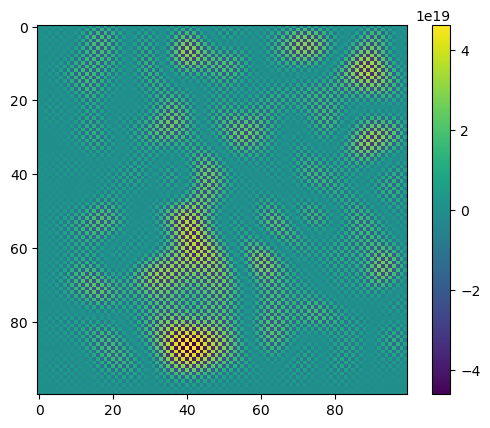

In [20]:
problem_mesh = problem_mesh.reshape(1, nx, ny, 1)

# descretised Laplacian operator by tf
w = ([[[[0.0],
        [0.15],
        [0.0]],

       [[0.25],
        [-0.8],
        [0.15]],

       [[0.0],
        [0.25],
        [0.0]]]])

init_bias = np.zeros((1,))
init_kernel = w
kernel_initializer_2 = tf.keras.initializers.constant(init_kernel)
bias_initializer = tf.keras.initializers.constant(init_bias)

CNN2D = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                           kernel_initializer=kernel_initializer_2,
                           bias_initializer=bias_initializer),
])

# CNN2D.compile(loss="mse",
#       optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))

problem_mesh_new = np.empty_like(problem_mesh)

start = perf_counter()
for t in range(100):
      problem_mesh_new = CNN2D.predict(problem_mesh)
      problem_mesh = np.copy(problem_mesh_new)
      
end = perf_counter()
print(f'[TIME CONSUMED] {end - start} sec')


plt.imshow(problem_mesh.reshape(100, 100))
plt.colorbar()


## Parallel using MPI routines

In [21]:
%%writefile decomposed_stencil_ai.py
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from time import perf_counter
from halos_exchange import HaloExchange
import sys
np.set_printoptions(threshold=sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # avoid tf dnn flag issue

nx, ny = 100, 100
problem_mesh = np.array([[4, 2, 1, 3, 2, 3, 2, 2, 3, 1, 1, 3, 1, 1, 2, 2, 3, 4, 4, 3, 2, 3,
                          4, 2, 3, 4, 4, 2, 4, 1, 4, 4, 4, 1, 2, 2, 4, 4, 4, 1, 4, 2, 4, 1,
                          3, 2, 1, 1, 2, 3, 3, 2, 2, 1, 2, 1, 2, 4, 3, 1, 3, 1, 3, 2, 3, 2,
                          2, 2, 2, 4, 4, 3, 4, 3, 1, 1, 2, 1, 3, 1, 3, 3, 3, 2, 3, 3, 4, 4,
                          3, 4, 1, 1, 4, 2, 1, 4, 3, 4, 4, 3],
                         [3, 3, 4, 2, 3, 2, 4, 3, 4, 4, 4, 2, 2, 4, 1, 1, 2, 4, 1, 4, 3, 1,
                          1, 1, 2, 3, 2, 4, 1, 3, 3, 1, 3, 2, 2, 1, 1, 1, 4, 2, 4, 4, 4, 2,
                          4, 2, 1, 1, 2, 1, 2, 1, 2, 3, 4, 1, 4, 1, 2, 3, 4, 4, 4, 3, 2, 3,
                          3, 2, 3, 3, 2, 2, 2, 3, 2, 4, 1, 3, 2, 1, 4, 3, 2, 2, 3, 2, 2, 4,
                          2, 3, 3, 4, 4, 3, 2, 3, 4, 4, 2, 3],
                         [4, 4, 4, 3, 3, 3, 4, 2, 4, 1, 4, 2, 4, 2, 2, 1, 2, 2, 2, 4, 1, 1,
                          2, 2, 1, 4, 2, 1, 3, 2, 3, 2, 2, 2, 4, 2, 2, 1, 2, 1, 4, 4, 3, 3,
                          1, 2, 2, 1, 1, 2, 2, 4, 3, 1, 3, 4, 3, 2, 4, 4, 4, 1, 1, 4, 4, 1,
                          3, 4, 3, 2, 4, 2, 2, 1, 2, 1, 1, 3, 1, 4, 1, 4, 3, 4, 3, 2, 4, 2,
                          1, 4, 2, 4, 1, 1, 3, 3, 1, 2, 2, 4],
                         [2, 2, 3, 1, 2, 4, 1, 2, 1, 2, 4, 3, 3, 2, 2, 2, 2, 4, 2, 1, 3, 2,
                          2, 3, 2, 3, 1, 2, 1, 4, 2, 1, 2, 2, 4, 1, 3, 4, 2, 3, 1, 1, 4, 1,
                          4, 2, 3, 2, 4, 4, 3, 2, 1, 3, 1, 1, 1, 1, 4, 4, 1, 3, 1, 2, 3, 1,
                          4, 3, 3, 3, 2, 3, 1, 3, 2, 2, 2, 3, 4, 3, 4, 3, 3, 4, 2, 2, 3, 3,
                          3, 1, 2, 3, 1, 1, 4, 2, 1, 2, 4, 4],
                         [2, 4, 4, 2, 1, 3, 4, 4, 1, 1, 2, 3, 3, 3, 1, 1, 2, 2, 4, 4, 4, 4,
                          4, 4, 1, 3, 4, 2, 4, 1, 2, 3, 2, 4, 3, 1, 2, 2, 1, 4, 2, 1, 1, 4,
                          3, 4, 1, 3, 2, 3, 3, 4, 1, 2, 2, 3, 4, 3, 2, 3, 3, 2, 1, 2, 4, 1,
                          4, 2, 3, 4, 3, 4, 4, 3, 1, 3, 3, 2, 2, 3, 2, 1, 2, 3, 4, 1, 4, 3,
                          2, 3, 4, 1, 1, 1, 4, 4, 1, 1, 2, 4],
                         [1, 3, 1, 1, 4, 4, 1, 3, 4, 4, 4, 4, 3, 1, 3, 1, 1, 3, 2, 1, 3, 2,
                          2, 2, 3, 1, 3, 4, 3, 4, 3, 4, 2, 2, 3, 1, 4, 3, 1, 1, 2, 4, 2, 4,
                          1, 2, 4, 1, 1, 2, 1, 3, 3, 1, 1, 2, 3, 3, 4, 4, 4, 1, 2, 3, 1, 3,
                          1, 3, 3, 3, 4, 1, 2, 2, 1, 1, 1, 2, 2, 1, 4, 1, 1, 2, 1, 2, 2, 1,
                          2, 1, 2, 2, 1, 4, 4, 2, 1, 2, 3, 3],
                         [1, 2, 4, 2, 2, 3, 1, 4, 4, 1, 4, 4, 4, 4, 4, 2, 2, 3, 1, 1, 2, 1,
                          1, 1, 4, 1, 3, 4, 3, 4, 2, 2, 4, 4, 3, 1, 3, 3, 1, 4, 2, 3, 3, 2,
                          3, 4, 1, 3, 3, 4, 4, 2, 4, 1, 1, 1, 4, 4, 2, 2, 2, 4, 1, 1, 1, 4,
                          3, 4, 3, 4, 1, 1, 4, 2, 1, 2, 3, 2, 2, 3, 2, 4, 3, 4, 4, 2, 1, 1,
                          3, 4, 1, 2, 4, 4, 1, 1, 2, 3, 2, 1],
                         [2, 2, 3, 1, 1, 2, 2, 3, 2, 4, 2, 3, 3, 3, 2, 2, 1, 3, 4, 3, 4, 4,
                          1, 1, 3, 4, 3, 4, 4, 1, 2, 1, 2, 4, 1, 4, 2, 4, 4, 1, 3, 1, 1, 4,
                          3, 2, 3, 2, 4, 1, 1, 4, 2, 1, 2, 4, 4, 3, 1, 3, 2, 3, 2, 2, 4, 1,
                          1, 2, 2, 1, 1, 4, 2, 2, 4, 3, 4, 2, 4, 4, 2, 1, 3, 4, 4, 4, 2, 4,
                          3, 3, 2, 2, 3, 3, 4, 1, 4, 4, 1, 1],
                         [2, 4, 4, 4, 1, 4, 4, 2, 2, 4, 3, 4, 4, 1, 1, 1, 2, 1, 3, 1, 4, 4,
                          2, 3, 4, 3, 4, 3, 1, 3, 2, 4, 1, 2, 3, 2, 2, 4, 4, 2, 3, 3, 1, 4,
                          4, 2, 4, 3, 3, 3, 4, 1, 1, 4, 1, 4, 2, 3, 3, 2, 3, 2, 4, 4, 3, 3,
                          1, 2, 4, 2, 1, 3, 3, 3, 1, 1, 4, 1, 3, 4, 2, 2, 3, 4, 4, 1, 4, 2,
                          1, 1, 4, 2, 3, 1, 3, 3, 1, 3, 3, 4],
                         [3, 2, 4, 1, 2, 2, 2, 3, 2, 2, 3, 3, 1, 3, 3, 2, 4, 1, 1, 1, 4, 1,
                          2, 2, 1, 1, 3, 3, 3, 1, 3, 4, 3, 4, 1, 2, 4, 2, 2, 3, 4, 2, 3, 2,
                          2, 2, 2, 2, 3, 4, 2, 1, 2, 4, 1, 3, 1, 1, 4, 1, 3, 3, 1, 3, 4, 1,
                          2, 1, 4, 4, 3, 4, 3, 3, 2, 4, 3, 4, 4, 4, 1, 2, 4, 3, 1, 4, 2, 3,
                          3, 3, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1],
                         [3, 3, 3, 2, 3, 1, 2, 3, 3, 1, 3, 4, 4, 3, 3, 3, 1, 1, 1, 3, 1, 1,
                          4, 4, 3, 4, 1, 3, 2, 4, 2, 4, 4, 2, 4, 3, 4, 2, 2, 4, 4, 4, 2, 2,
                          1, 1, 1, 3, 4, 2, 2, 4, 2, 4, 3, 1, 4, 3, 4, 3, 2, 3, 2, 3, 1, 1,
                          2, 3, 2, 3, 2, 1, 3, 1, 2, 2, 1, 4, 1, 1, 2, 1, 3, 1, 3, 1, 1, 2,
                          2, 3, 2, 4, 1, 1, 3, 3, 2, 3, 3, 1],
                         [1, 2, 4, 4, 4, 2, 1, 4, 4, 4, 4, 1, 2, 4, 3, 2, 2, 2, 2, 4, 2, 1,
                          3, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 4, 1, 3, 2, 4, 2, 2, 2, 1,
                          2, 3, 3, 2, 1, 3, 3, 2, 4, 3, 1, 3, 3, 1, 2, 2, 3, 3, 3, 3, 2, 1,
                          3, 1, 3, 3, 1, 1, 4, 1, 4, 3, 1, 4, 4, 1, 2, 2, 3, 1, 3, 4, 3, 4,
                          3, 1, 4, 2, 4, 1, 2, 1, 1, 3, 2, 3],
                         [2, 3, 2, 1, 1, 2, 2, 2, 3, 1, 1, 1, 1, 3, 3, 1, 3, 2, 3, 2, 2, 4,
                          4, 3, 4, 1, 4, 4, 4, 4, 2, 4, 4, 1, 1, 2, 2, 1, 2, 3, 4, 2, 2, 3,
                          4, 3, 2, 2, 1, 2, 1, 3, 4, 1, 1, 4, 4, 3, 1, 3, 4, 4, 1, 1, 2, 3,
                          2, 4, 4, 3, 1, 3, 2, 2, 2, 2, 4, 4, 1, 1, 1, 3, 2, 1, 3, 1, 1, 1,
                          2, 3, 2, 4, 3, 4, 4, 3, 2, 3, 4, 4],
                         [1, 1, 2, 2, 2, 4, 2, 4, 4, 4, 2, 4, 2, 3, 1, 2, 1, 2, 1, 3, 4, 2,
                          4, 4, 2, 3, 1, 3, 3, 1, 2, 4, 1, 4, 2, 3, 3, 3, 1, 3, 4, 4, 2, 3,
                          4, 2, 4, 3, 4, 3, 1, 3, 2, 3, 3, 4, 4, 2, 4, 3, 1, 4, 2, 2, 4, 3,
                          3, 3, 4, 1, 3, 2, 3, 2, 1, 3, 4, 4, 4, 3, 3, 1, 3, 3, 1, 4, 3, 4,
                          1, 2, 3, 4, 3, 1, 3, 1, 4, 4, 2, 4],
                         [1, 4, 1, 2, 3, 3, 2, 1, 1, 4, 3, 2, 1, 2, 2, 3, 2, 2, 1, 1, 1, 4,
                          1, 3, 3, 1, 1, 1, 4, 2, 2, 3, 4, 3, 4, 4, 4, 4, 3, 3, 1, 3, 2, 4,
                          1, 4, 4, 1, 4, 2, 3, 4, 4, 2, 2, 3, 1, 3, 1, 1, 2, 4, 2, 1, 3, 1,
                          3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2, 4, 4, 2, 4, 4, 3, 2, 4, 3,
                          4, 4, 1, 3, 1, 3, 3, 1, 4, 2, 2, 2],
                         [2, 1, 2, 3, 2, 2, 3, 2, 1, 4, 3, 2, 2, 1, 1, 1, 3, 1, 3, 2, 3, 3,
                          2, 1, 1, 1, 3, 3, 4, 2, 4, 3, 1, 4, 3, 4, 2, 1, 1, 1, 2, 3, 2, 4,
                          1, 4, 2, 3, 1, 2, 1, 2, 3, 3, 3, 1, 1, 2, 2, 3, 2, 1, 2, 1, 4, 2,
                          1, 3, 2, 2, 4, 3, 4, 1, 3, 4, 3, 3, 2, 3, 1, 1, 1, 4, 2, 1, 2, 2,
                          3, 2, 2, 4, 3, 2, 4, 3, 3, 4, 1, 4],
                         [3, 1, 3, 3, 2, 4, 1, 1, 4, 2, 3, 2, 1, 4, 3, 1, 2, 2, 2, 1, 3, 4,
                          2, 4, 3, 3, 1, 1, 1, 1, 4, 1, 1, 1, 2, 3, 3, 2, 1, 2, 2, 3, 3, 1,
                          2, 1, 1, 1, 4, 3, 2, 1, 1, 1, 3, 4, 4, 2, 1, 4, 4, 3, 3, 1, 2, 3,
                          2, 4, 1, 2, 2, 3, 1, 3, 2, 1, 4, 3, 1, 2, 2, 2, 4, 4, 2, 2, 2, 3,
                          1, 3, 4, 3, 2, 1, 3, 2, 1, 2, 3, 4],
                         [3, 3, 1, 3, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 4, 1, 1, 1, 4, 1, 3,
                          3, 4, 3, 1, 3, 1, 1, 4, 1, 3, 1, 3, 2, 2, 4, 3, 2, 4, 3, 1, 1, 2,
                          1, 1, 1, 1, 3, 1, 4, 2, 3, 4, 3, 1, 3, 1, 1, 3, 2, 3, 2, 1, 2, 2,
                          3, 2, 1, 4, 4, 2, 2, 3, 1, 3, 2, 4, 2, 4, 2, 3, 3, 2, 3, 1, 4, 3,
                          3, 3, 1, 3, 4, 3, 1, 2, 1, 3, 1, 4],
                         [3, 2, 4, 4, 3, 4, 2, 2, 1, 3, 2, 2, 4, 1, 2, 3, 4, 1, 4, 1, 2, 2,
                          2, 4, 1, 3, 2, 1, 4, 3, 1, 2, 4, 2, 2, 3, 1, 3, 3, 1, 3, 2, 4, 1,
                          3, 2, 4, 3, 4, 4, 4, 3, 3, 4, 4, 3, 2, 1, 4, 3, 3, 1, 2, 4, 1, 2,
                          3, 3, 4, 2, 4, 4, 2, 2, 1, 4, 1, 3, 3, 1, 1, 1, 2, 1, 1, 4, 3, 2,
                          4, 1, 1, 2, 2, 1, 3, 4, 4, 2, 2, 1],
                         [2, 3, 2, 2, 2, 1, 3, 4, 3, 2, 3, 3, 2, 1, 3, 1, 3, 4, 4, 2, 3, 3,
                          3, 1, 3, 1, 2, 2, 4, 3, 2, 4, 1, 3, 4, 2, 4, 4, 4, 3, 4, 2, 4, 4,
                          1, 4, 4, 3, 4, 2, 3, 4, 2, 3, 2, 1, 4, 4, 1, 1, 4, 2, 3, 3, 3, 1,
                          1, 2, 3, 4, 3, 2, 1, 4, 1, 2, 3, 2, 1, 4, 2, 3, 1, 3, 1, 4, 2, 4,
                          1, 4, 2, 3, 4, 2, 4, 1, 3, 4, 1, 1],
                         [2, 3, 4, 2, 4, 3, 4, 2, 4, 3, 4, 4, 2, 3, 4, 1, 3, 3, 4, 1, 1, 2,
                          2, 2, 1, 2, 3, 4, 2, 2, 2, 1, 2, 1, 2, 1, 1, 3, 4, 4, 3, 1, 4, 1,
                          3, 3, 4, 2, 3, 2, 4, 2, 1, 2, 1, 2, 2, 3, 2, 2, 1, 4, 2, 1, 4, 2,
                          1, 1, 3, 2, 1, 3, 1, 3, 2, 3, 4, 1, 3, 2, 4, 2, 3, 1, 3, 4, 4, 2,
                          2, 2, 2, 4, 4, 4, 4, 3, 2, 4, 4, 4],
                         [3, 2, 2, 4, 1, 4, 2, 1, 4, 2, 2, 3, 4, 1, 3, 4, 4, 1, 2, 2, 3, 3,
                          2, 3, 4, 2, 2, 2, 4, 1, 1, 1, 4, 3, 2, 2, 4, 3, 3, 2, 4, 1, 3, 2,
                          1, 4, 3, 1, 1, 2, 4, 1, 4, 4, 1, 4, 2, 2, 3, 4, 4, 3, 4, 3, 1, 4,
                          4, 4, 1, 1, 3, 3, 3, 2, 1, 2, 2, 2, 3, 4, 4, 1, 1, 2, 4, 4, 3, 4,
                          3, 1, 3, 1, 3, 2, 3, 1, 1, 3, 4, 2],
                         [1, 4, 2, 2, 4, 2, 2, 3, 4, 1, 3, 2, 4, 2, 1, 3, 4, 1, 4, 3, 2, 2,
                          1, 3, 3, 2, 1, 4, 2, 1, 1, 2, 4, 2, 4, 4, 2, 4, 4, 3, 1, 2, 1, 1,
                          1, 2, 4, 3, 1, 4, 3, 4, 1, 2, 4, 2, 4, 1, 3, 3, 3, 4, 2, 1, 4, 3,
                          1, 2, 4, 1, 4, 3, 4, 3, 4, 4, 4, 3, 2, 1, 1, 2, 2, 2, 4, 3, 4, 4,
                          4, 2, 4, 2, 2, 3, 1, 2, 2, 1, 4, 3],
                         [3, 2, 1, 2, 1, 4, 2, 3, 1, 2, 1, 2, 1, 2, 4, 3, 4, 1, 3, 2, 4, 2,
                          2, 3, 2, 3, 2, 1, 3, 3, 2, 4, 3, 2, 4, 1, 2, 4, 3, 1, 2, 4, 3, 1,
                          4, 1, 3, 2, 1, 3, 4, 3, 1, 1, 3, 2, 4, 3, 4, 2, 3, 3, 3, 1, 1, 4,
                          2, 2, 3, 3, 4, 4, 1, 2, 1, 3, 4, 3, 1, 4, 3, 1, 2, 1, 1, 3, 2, 3,
                          3, 4, 4, 3, 2, 3, 1, 4, 4, 3, 4, 3],
                         [1, 2, 2, 3, 2, 3, 2, 4, 4, 1, 1, 3, 4, 4, 2, 3, 1, 3, 4, 3, 4, 2,
                          2, 1, 3, 2, 2, 4, 1, 3, 3, 3, 3, 3, 4, 2, 1, 4, 1, 1, 3, 1, 1, 2,
                          4, 4, 1, 2, 4, 2, 1, 1, 4, 1, 3, 1, 2, 4, 4, 1, 4, 2, 2, 3, 2, 2,
                          3, 1, 3, 1, 3, 3, 2, 4, 3, 3, 2, 2, 2, 2, 1, 3, 2, 2, 4, 2, 4, 1,
                          2, 1, 2, 4, 4, 2, 3, 4, 4, 1, 3, 4],
                         [1, 2, 2, 1, 4, 1, 2, 2, 1, 2, 1, 1, 4, 4, 2, 4, 3, 4, 3, 3, 3, 4,
                          2, 1, 1, 1, 2, 4, 4, 2, 2, 3, 4, 4, 1, 4, 1, 4, 1, 4, 1, 1, 2, 2,
                          1, 3, 4, 1, 1, 3, 4, 3, 3, 1, 4, 2, 4, 3, 2, 4, 1, 1, 2, 1, 3, 1,
                          3, 2, 1, 2, 4, 1, 3, 2, 2, 1, 2, 2, 3, 1, 4, 2, 4, 1, 4, 4, 4, 3,
                          1, 3, 3, 4, 4, 1, 4, 4, 2, 4, 4, 1],
                         [1, 2, 1, 3, 4, 1, 4, 2, 1, 1, 3, 3, 2, 3, 3, 2, 1, 4, 3, 3, 3, 3,
                          4, 1, 1, 2, 3, 3, 4, 1, 1, 1, 2, 3, 3, 4, 2, 4, 1, 1, 1, 1, 2, 2,
                          2, 2, 2, 1, 1, 1, 2, 1, 2, 4, 1, 3, 4, 1, 3, 1, 1, 4, 3, 2, 4, 4,
                          2, 2, 2, 4, 4, 1, 1, 4, 3, 2, 2, 4, 3, 1, 2, 4, 4, 3, 3, 4, 4, 3,
                          3, 4, 1, 4, 3, 1, 3, 4, 3, 4, 4, 1],
                         [3, 1, 2, 1, 3, 3, 3, 1, 2, 2, 3, 1, 3, 2, 1, 1, 2, 2, 3, 4, 2, 2,
                          3, 3, 3, 3, 2, 4, 4, 1, 3, 3, 1, 1, 4, 3, 4, 1, 4, 4, 2, 1, 2, 1,
                          2, 1, 1, 2, 1, 2, 4, 1, 3, 4, 1, 4, 1, 3, 4, 2, 1, 3, 1, 3, 4, 4,
                          4, 1, 3, 1, 3, 3, 1, 4, 1, 3, 3, 4, 1, 1, 3, 3, 2, 2, 3, 4, 4, 1,
                          1, 2, 4, 4, 1, 2, 3, 4, 1, 2, 3, 3],
                         [2, 4, 2, 1, 2, 2, 3, 1, 3, 4, 4, 2, 1, 2, 3, 3, 2, 2, 2, 2, 2, 1,
                          4, 2, 1, 1, 1, 1, 3, 3, 3, 2, 4, 4, 1, 1, 4, 3, 3, 1, 2, 2, 4, 1,
                          3, 3, 4, 2, 1, 1, 2, 4, 4, 2, 3, 3, 1, 1, 1, 4, 3, 3, 4, 2, 3, 1,
                          3, 2, 2, 3, 2, 1, 1, 4, 3, 2, 4, 2, 1, 2, 3, 1, 3, 3, 4, 2, 2, 1,
                          1, 4, 1, 3, 2, 3, 4, 1, 4, 1, 3, 3],
                         [1, 2, 3, 2, 2, 1, 3, 3, 1, 2, 3, 4, 2, 1, 2, 4, 3, 2, 3, 2, 3, 4,
                          3, 4, 4, 2, 4, 4, 3, 3, 4, 1, 4, 1, 4, 4, 3, 4, 2, 3, 4, 2, 4, 2,
                          2, 3, 2, 1, 3, 3, 3, 3, 1, 1, 1, 2, 1, 1, 1, 3, 1, 2, 4, 3, 1, 3,
                          1, 4, 1, 2, 1, 1, 1, 1, 1, 3, 4, 4, 2, 3, 4, 4, 3, 4, 2, 1, 4, 4,
                          1, 3, 2, 1, 1, 1, 4, 3, 1, 1, 3, 4],
                         [3, 4, 2, 2, 1, 3, 4, 2, 3, 2, 4, 2, 4, 2, 1, 3, 3, 1, 3, 1, 1, 3,
                          4, 1, 2, 4, 2, 3, 2, 2, 4, 4, 2, 2, 2, 4, 3, 2, 3, 3, 2, 2, 4, 1,
                          3, 4, 2, 1, 3, 1, 3, 4, 1, 2, 4, 1, 4, 2, 2, 2, 3, 3, 2, 4, 2, 4,
                          1, 2, 2, 1, 2, 4, 4, 2, 1, 4, 1, 1, 1, 3, 2, 1, 1, 1, 3, 4, 2, 1,
                          4, 2, 1, 1, 3, 1, 1, 1, 1, 4, 3, 1],
                         [2, 2, 4, 4, 3, 4, 1, 4, 4, 1, 2, 2, 2, 1, 3, 2, 3, 2, 1, 2, 3, 1,
                          2, 2, 2, 1, 4, 1, 2, 1, 3, 3, 3, 3, 3, 4, 4, 3, 1, 4, 3, 2, 1, 4,
                          1, 3, 3, 1, 4, 2, 3, 1, 2, 1, 4, 1, 1, 1, 4, 2, 4, 1, 1, 2, 2, 4,
                          3, 3, 1, 4, 4, 3, 1, 3, 1, 3, 3, 1, 2, 1, 3, 4, 1, 2, 3, 4, 4, 4,
                          3, 1, 1, 3, 2, 4, 2, 1, 2, 1, 1, 4],
                         [2, 3, 2, 3, 2, 4, 2, 2, 3, 4, 2, 1, 2, 1, 4, 2, 1, 2, 2, 1, 2, 1,
                          4, 1, 3, 3, 3, 2, 4, 1, 1, 1, 1, 3, 3, 2, 2, 3, 1, 4, 4, 4, 4, 3,
                          2, 4, 1, 2, 1, 1, 2, 3, 4, 4, 1, 2, 4, 4, 2, 2, 3, 2, 1, 3, 1, 3,
                          3, 4, 2, 2, 4, 4, 4, 1, 4, 4, 2, 4, 4, 2, 2, 2, 2, 1, 1, 2, 2, 4,
                          2, 3, 2, 2, 4, 4, 4, 2, 3, 2, 2, 2],
                         [2, 4, 2, 3, 4, 3, 2, 3, 3, 2, 2, 1, 3, 1, 4, 4, 4, 4, 2, 2, 3, 4,
                          3, 1, 4, 4, 3, 1, 1, 2, 3, 1, 2, 2, 1, 2, 3, 4, 1, 3, 1, 3, 4, 4,
                          3, 4, 1, 2, 4, 3, 1, 2, 2, 4, 2, 3, 3, 3, 2, 2, 3, 1, 3, 2, 3, 2,
                          4, 2, 1, 3, 2, 1, 4, 4, 1, 2, 2, 2, 1, 4, 3, 3, 4, 1, 4, 2, 3, 2,
                          2, 2, 2, 4, 1, 3, 4, 1, 3, 2, 2, 1],
                         [1, 2, 1, 3, 1, 1, 4, 1, 3, 1, 2, 3, 4, 4, 2, 4, 2, 4, 2, 4, 1, 1,
                          3, 4, 4, 2, 3, 2, 4, 4, 3, 4, 3, 4, 3, 4, 4, 2, 2, 4, 4, 3, 1, 3,
                          1, 4, 4, 2, 1, 1, 4, 1, 2, 2, 3, 1, 4, 2, 3, 1, 4, 3, 2, 1, 1, 3,
                          1, 1, 3, 2, 4, 3, 2, 4, 2, 1, 3, 3, 3, 4, 1, 2, 4, 3, 2, 1, 1, 1,
                          2, 4, 1, 4, 1, 1, 1, 4, 4, 1, 2, 3],
                         [3, 4, 1, 2, 1, 3, 1, 4, 4, 3, 4, 4, 2, 2, 4, 2, 4, 4, 1, 2, 4, 1,
                          3, 1, 4, 3, 4, 1, 3, 3, 4, 3, 4, 1, 2, 3, 4, 3, 2, 1, 1, 1, 1, 1,
                          1, 3, 2, 4, 1, 4, 2, 4, 3, 1, 1, 3, 4, 1, 1, 3, 3, 4, 4, 3, 1, 3,
                          2, 4, 1, 4, 2, 1, 3, 3, 2, 2, 1, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 4,
                          2, 1, 4, 2, 4, 2, 4, 4, 3, 1, 4, 1],
                         [3, 1, 4, 4, 1, 2, 1, 3, 1, 3, 2, 1, 2, 4, 4, 4, 3, 2, 3, 2, 2, 2,
                          1, 1, 1, 2, 2, 1, 4, 3, 3, 2, 4, 3, 1, 3, 4, 3, 3, 2, 1, 1, 1, 2,
                          4, 3, 1, 1, 2, 2, 3, 3, 1, 1, 3, 3, 1, 1, 4, 1, 1, 3, 1, 2, 2, 3,
                          1, 3, 1, 3, 2, 1, 4, 1, 1, 3, 2, 2, 2, 4, 1, 3, 1, 3, 2, 3, 1, 2,
                          1, 3, 4, 1, 1, 2, 4, 4, 2, 3, 2, 4],
                         [1, 1, 4, 1, 4, 4, 1, 2, 1, 2, 2, 3, 2, 3, 4, 3, 4, 4, 4, 3, 3, 1,
                          4, 3, 1, 2, 3, 1, 3, 1, 4, 3, 3, 4, 3, 3, 3, 1, 2, 1, 4, 4, 2, 2,
                          4, 2, 2, 4, 1, 1, 1, 2, 4, 4, 2, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 2,
                          4, 2, 1, 1, 1, 3, 2, 4, 1, 3, 3, 3, 2, 2, 4, 1, 3, 1, 1, 1, 1, 3,
                          3, 2, 2, 2, 4, 2, 3, 3, 1, 2, 2, 2],
                         [3, 3, 1, 1, 2, 1, 4, 1, 2, 1, 4, 1, 3, 2, 1, 1, 4, 2, 2, 1, 3, 4,
                          2, 4, 3, 2, 4, 4, 2, 4, 1, 2, 2, 1, 4, 3, 1, 1, 1, 2, 2, 1, 4, 4,
                          4, 3, 3, 1, 3, 4, 4, 3, 3, 1, 4, 2, 3, 3, 1, 3, 2, 1, 4, 2, 1, 2,
                          2, 1, 4, 4, 1, 1, 1, 1, 4, 4, 3, 1, 1, 4, 3, 4, 3, 4, 2, 3, 1, 4,
                          1, 4, 1, 4, 4, 2, 2, 4, 4, 4, 4, 4],
                         [1, 3, 1, 2, 4, 2, 4, 3, 3, 4, 1, 3, 3, 4, 2, 2, 2, 4, 1, 4, 1, 3,
                          4, 4, 2, 3, 2, 3, 3, 2, 1, 1, 4, 4, 2, 1, 4, 4, 3, 3, 3, 3, 1, 1,
                          4, 1, 1, 4, 2, 4, 3, 2, 4, 3, 4, 3, 3, 4, 3, 1, 3, 3, 1, 3, 1, 1,
                          1, 2, 4, 2, 3, 2, 4, 3, 2, 4, 3, 4, 3, 2, 4, 2, 2, 4, 3, 4, 3, 4,
                          4, 4, 1, 2, 2, 2, 4, 3, 2, 4, 4, 3],
                         [4, 3, 3, 1, 3, 3, 1, 4, 2, 1, 4, 1, 3, 1, 1, 1, 1, 4, 2, 4, 4, 1,
                          1, 3, 4, 4, 3, 4, 4, 3, 4, 2, 4, 2, 4, 3, 2, 3, 3, 3, 4, 3, 4, 1,
                          3, 2, 2, 3, 2, 2, 2, 4, 4, 2, 1, 3, 4, 4, 3, 2, 3, 2, 3, 3, 4, 4,
                          2, 2, 3, 3, 1, 2, 1, 1, 1, 3, 3, 3, 2, 2, 3, 2, 3, 3, 1, 3, 3, 1,
                          2, 2, 3, 1, 1, 1, 2, 3, 2, 2, 2, 3],
                         [3, 4, 4, 2, 2, 2, 1, 2, 4, 1, 3, 4, 4, 2, 2, 2, 4, 4, 3, 1, 1, 2,
                          1, 2, 3, 4, 1, 4, 4, 2, 4, 4, 3, 4, 3, 2, 1, 2, 2, 2, 2, 2, 4, 4,
                          2, 2, 1, 2, 3, 2, 3, 3, 1, 2, 3, 1, 3, 2, 2, 2, 4, 1, 4, 4, 3, 2,
                          3, 4, 1, 1, 3, 4, 1, 1, 4, 2, 4, 1, 4, 2, 4, 1, 3, 4, 2, 1, 1, 4,
                          2, 4, 4, 4, 4, 3, 1, 2, 3, 3, 1, 2],
                         [1, 2, 4, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 4, 2, 4, 2,
                          2, 1, 1, 4, 2, 2, 2, 2, 1, 2, 4, 1, 1, 1, 3, 4, 4, 3, 1, 4, 2, 3,
                          1, 4, 4, 1, 2, 3, 1, 1, 2, 4, 4, 4, 4, 3, 4, 1, 1, 2, 3, 4, 2, 2,
                          2, 2, 4, 3, 1, 3, 4, 3, 3, 1, 4, 2, 3, 2, 1, 2, 2, 4, 1, 2, 3, 1,
                          3, 3, 1, 1, 2, 2, 2, 1, 2, 3, 1, 4],
                         [3, 3, 4, 4, 3, 2, 4, 1, 1, 4, 1, 2, 3, 4, 3, 3, 3, 1, 3, 3, 2, 4,
                          4, 3, 3, 1, 1, 2, 1, 1, 2, 3, 2, 1, 2, 1, 3, 4, 2, 2, 3, 1, 2, 1,
                          3, 4, 1, 3, 4, 2, 2, 2, 2, 2, 3, 4, 3, 3, 1, 1, 2, 2, 4, 1, 4, 3,
                          4, 2, 1, 4, 3, 1, 3, 4, 3, 1, 4, 3, 2, 2, 1, 2, 1, 3, 3, 4, 2, 2,
                          4, 2, 4, 1, 1, 2, 1, 2, 2, 3, 1, 3],
                         [1, 3, 2, 1, 1, 3, 3, 4, 1, 4, 2, 1, 1, 4, 3, 2, 4, 3, 1, 3, 3, 4,
                          3, 3, 1, 4, 2, 3, 2, 4, 4, 1, 4, 1, 1, 4, 3, 4, 3, 4, 2, 3, 3, 4,
                          4, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 4, 3, 1, 3, 1, 2, 3, 3, 2, 4, 2,
                          1, 4, 2, 2, 4, 4, 3, 2, 4, 1, 3, 4, 2, 3, 4, 3, 2, 4, 2, 4, 3, 1,
                          1, 1, 3, 2, 2, 2, 1, 2, 4, 3, 3, 4],
                         [1, 1, 4, 2, 1, 2, 3, 1, 4, 2, 4, 1, 3, 1, 1, 2, 4, 3, 4, 4, 3, 3,
                          3, 2, 2, 4, 2, 2, 2, 4, 2, 1, 1, 2, 4, 1, 4, 1, 4, 2, 3, 1, 2, 2,
                          1, 2, 3, 1, 2, 3, 2, 1, 3, 3, 4, 3, 1, 3, 1, 3, 1, 3, 2, 1, 4, 3,
                          1, 1, 1, 1, 4, 3, 2, 2, 2, 2, 4, 4, 3, 1, 2, 4, 1, 4, 4, 1, 4, 3,
                          4, 4, 2, 1, 2, 4, 2, 2, 3, 4, 3, 3],
                         [3, 3, 4, 3, 4, 4, 4, 2, 3, 1, 3, 2, 3, 1, 2, 3, 3, 2, 2, 2, 4, 4,
                          2, 3, 2, 3, 1, 1, 3, 4, 3, 2, 3, 4, 1, 1, 4, 3, 4, 4, 1, 2, 1, 1,
                          4, 4, 4, 2, 3, 2, 4, 4, 1, 1, 2, 2, 3, 2, 1, 1, 4, 3, 3, 3, 4, 3,
                          3, 3, 2, 2, 4, 2, 3, 3, 2, 3, 4, 2, 4, 1, 1, 1, 4, 4, 3, 2, 3, 3,
                          3, 1, 3, 2, 4, 1, 2, 1, 3, 1, 3, 3],
                         [3, 3, 2, 3, 3, 2, 4, 4, 3, 4, 3, 3, 3, 4, 3, 1, 2, 3, 3, 4, 3, 1,
                          2, 2, 1, 2, 2, 4, 1, 4, 2, 3, 3, 2, 4, 1, 1, 1, 2, 4, 1, 3, 4, 1,
                          1, 4, 4, 4, 1, 4, 2, 3, 3, 2, 3, 3, 2, 1, 4, 2, 1, 3, 4, 3, 4, 2,
                          3, 1, 4, 3, 3, 2, 2, 4, 1, 2, 2, 1, 4, 4, 4, 2, 2, 2, 2, 1, 2, 4,
                          4, 4, 3, 2, 3, 2, 3, 4, 2, 4, 1, 3],
                         [1, 4, 2, 3, 3, 1, 3, 4, 4, 1, 3, 4, 3, 2, 1, 3, 2, 1, 1, 4, 1, 3,
                          4, 2, 4, 1, 1, 3, 2, 2, 3, 1, 2, 2, 3, 4, 3, 4, 4, 3, 1, 4, 2, 4,
                          1, 1, 3, 3, 1, 4, 1, 1, 2, 3, 2, 3, 1, 2, 4, 1, 1, 3, 3, 3, 2, 4,
                          4, 4, 3, 2, 4, 4, 3, 3, 2, 3, 4, 3, 3, 1, 1, 3, 4, 4, 1, 3, 1, 2,
                          4, 3, 2, 4, 4, 3, 3, 4, 2, 1, 3, 4],
                         [1, 4, 3, 1, 1, 3, 3, 3, 3, 4, 3, 4, 4, 1, 3, 4, 1, 3, 1, 1, 4, 2,
                          4, 2, 4, 2, 2, 3, 3, 3, 3, 2, 1, 3, 3, 1, 1, 4, 1, 4, 1, 4, 3, 1,
                          4, 1, 1, 3, 3, 2, 1, 1, 4, 4, 3, 2, 1, 2, 4, 4, 2, 3, 2, 4, 4, 1,
                          2, 2, 3, 1, 3, 2, 4, 2, 4, 4, 2, 3, 4, 4, 4, 4, 2, 3, 1, 1, 2, 1,
                          2, 2, 2, 3, 4, 4, 4, 4, 4, 2, 2, 4],
                         [1, 1, 1, 2, 1, 1, 4, 3, 2, 1, 2, 3, 4, 4, 4, 2, 3, 3, 1, 2, 3, 4,
                          1, 3, 3, 2, 3, 3, 3, 1, 2, 1, 3, 1, 4, 4, 3, 3, 3, 4, 1, 4, 1, 1,
                          4, 2, 4, 2, 3, 3, 2, 3, 3, 2, 3, 2, 4, 4, 4, 1, 1, 2, 1, 1, 4, 4,
                          3, 3, 4, 1, 3, 4, 1, 4, 4, 2, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 4, 4,
                          4, 4, 2, 2, 1, 2, 1, 3, 2, 1, 1, 3],
                         [1, 3, 4, 1, 2, 3, 2, 3, 4, 4, 2, 3, 3, 1, 2, 4, 3, 4, 3, 1, 3, 3,
                          3, 1, 4, 2, 2, 1, 3, 4, 3, 4, 1, 3, 4, 4, 3, 2, 1, 1, 2, 3, 1, 3,
                          4, 4, 4, 1, 3, 1, 3, 3, 3, 1, 4, 2, 2, 4, 4, 4, 1, 2, 2, 4, 4, 1,
                          3, 4, 2, 4, 2, 1, 4, 2, 1, 2, 4, 2, 2, 4, 2, 3, 1, 1, 1, 1, 2, 4,
                          2, 2, 4, 4, 2, 4, 2, 3, 4, 2, 2, 2],
                         [3, 2, 2, 2, 4, 3, 2, 2, 4, 1, 2, 4, 2, 3, 2, 3, 2, 1, 2, 2, 4, 2,
                          2, 4, 4, 1, 3, 2, 2, 4, 4, 1, 2, 2, 4, 2, 1, 4, 1, 1, 3, 4, 1, 2,
                          3, 1, 2, 3, 2, 3, 4, 4, 4, 3, 1, 2, 3, 2, 1, 4, 1, 2, 3, 4, 3, 1,
                          1, 3, 2, 4, 1, 4, 2, 1, 1, 3, 2, 4, 1, 3, 3, 1, 3, 1, 2, 1, 4, 2,
                          1, 1, 1, 1, 2, 3, 4, 3, 2, 4, 4, 1],
                         [1, 1, 1, 1, 1, 1, 4, 3, 1, 4, 4, 4, 2, 2, 4, 2, 2, 3, 1, 3, 2, 3,
                          1, 3, 4, 4, 3, 2, 2, 1, 2, 4, 1, 1, 1, 3, 3, 1, 3, 1, 4, 2, 4, 2,
                          4, 4, 1, 2, 1, 2, 2, 4, 3, 4, 1, 3, 3, 1, 4, 2, 1, 1, 1, 3, 4, 2,
                          4, 3, 1, 4, 3, 4, 3, 2, 3, 3, 2, 1, 3, 2, 3, 1, 2, 4, 4, 3, 2, 3,
                          1, 4, 2, 3, 1, 1, 2, 1, 2, 2, 3, 2],
                         [2, 4, 3, 2, 2, 1, 1, 2, 3, 4, 2, 3, 1, 4, 3, 3, 1, 2, 2, 1, 4, 2,
                          4, 1, 4, 3, 3, 2, 3, 2, 2, 3, 3, 4, 4, 4, 1, 3, 2, 2, 3, 2, 1, 4,
                          4, 3, 2, 2, 3, 1, 4, 3, 4, 4, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 4, 1,
                          1, 1, 3, 1, 4, 4, 3, 4, 1, 1, 2, 2, 4, 2, 2, 4, 1, 2, 1, 2, 4, 4,
                          2, 1, 4, 4, 1, 1, 3, 1, 1, 2, 1, 3],
                         [3, 1, 2, 3, 2, 3, 4, 4, 4, 1, 3, 1, 1, 2, 2, 1, 2, 4, 2, 3, 2, 3,
                          4, 1, 3, 3, 3, 1, 2, 3, 1, 2, 4, 1, 3, 4, 2, 2, 4, 3, 4, 3, 3, 4,
                          3, 4, 4, 4, 3, 3, 4, 1, 3, 3, 2, 1, 3, 3, 3, 3, 1, 2, 2, 1, 2, 2,
                          4, 3, 3, 3, 4, 3, 1, 4, 4, 3, 2, 4, 2, 1, 2, 2, 3, 4, 4, 1, 3, 4,
                          1, 4, 3, 3, 4, 2, 4, 2, 1, 2, 1, 2],
                         [2, 1, 4, 2, 2, 1, 1, 4, 3, 2, 3, 4, 3, 4, 4, 3, 4, 1, 1, 1, 1, 1,
                          4, 1, 1, 4, 1, 4, 2, 4, 1, 3, 1, 3, 1, 4, 4, 1, 2, 3, 3, 1, 2, 4,
                          4, 4, 4, 1, 4, 3, 3, 1, 4, 1, 4, 2, 3, 3, 4, 4, 3, 4, 4, 1, 3, 3,
                          4, 4, 3, 2, 1, 4, 2, 1, 2, 1, 1, 2, 4, 4, 2, 3, 3, 1, 4, 4, 3, 1,
                          4, 3, 1, 4, 1, 3, 3, 2, 1, 1, 3, 2],
                         [2, 1, 3, 4, 4, 4, 4, 4, 1, 2, 1, 2, 4, 2, 1, 2, 4, 2, 4, 1, 4, 4,
                          2, 1, 1, 1, 1, 2, 4, 1, 3, 2, 1, 4, 3, 1, 4, 2, 1, 3, 3, 2, 3, 4,
                          1, 1, 4, 1, 4, 2, 3, 2, 4, 1, 2, 1, 2, 1, 4, 2, 1, 2, 3, 4, 1, 3,
                          3, 4, 1, 4, 2, 2, 3, 4, 2, 4, 3, 2, 2, 3, 3, 3, 4, 2, 4, 3, 4, 1,
                          3, 1, 4, 3, 1, 3, 2, 2, 1, 1, 3, 2],
                         [2, 2, 4, 4, 1, 2, 4, 4, 2, 1, 3, 2, 2, 4, 3, 1, 3, 3, 4, 3, 1, 3,
                          2, 1, 3, 1, 1, 3, 3, 3, 2, 4, 1, 2, 2, 3, 3, 3, 4, 3, 3, 3, 2, 4,
                          4, 1, 3, 1, 2, 4, 1, 3, 3, 3, 4, 4, 3, 3, 1, 2, 2, 2, 4, 1, 2, 2,
                          2, 2, 1, 3, 4, 1, 3, 2, 1, 2, 1, 1, 4, 3, 2, 3, 2, 4, 1, 4, 3, 2,
                          4, 3, 4, 3, 3, 1, 4, 4, 3, 1, 2, 3],
                         [3, 4, 3, 1, 3, 1, 3, 4, 4, 4, 3, 1, 1, 1, 3, 4, 3, 1, 1, 2, 2, 1,
                          1, 2, 4, 2, 1, 2, 1, 2, 3, 1, 4, 1, 2, 4, 3, 4, 2, 3, 2, 3, 2, 1,
                          4, 3, 2, 4, 1, 3, 1, 4, 4, 1, 4, 2, 4, 1, 2, 2, 4, 2, 2, 3, 2, 1,
                          1, 1, 1, 4, 1, 1, 2, 2, 1, 1, 4, 2, 3, 1, 3, 2, 2, 2, 4, 2, 3, 4,
                          3, 2, 4, 3, 3, 4, 4, 3, 4, 4, 4, 4],
                         [2, 1, 2, 4, 2, 1, 1, 3, 3, 3, 2, 4, 3, 2, 1, 3, 1, 2, 4, 3, 4, 4,
                          4, 3, 3, 1, 3, 2, 3, 3, 2, 4, 1, 2, 4, 2, 4, 2, 1, 2, 3, 2, 1, 3,
                          2, 1, 3, 4, 3, 1, 1, 4, 3, 2, 2, 4, 2, 2, 1, 3, 2, 3, 2, 1, 3, 1,
                          3, 1, 4, 4, 4, 2, 2, 2, 4, 3, 2, 4, 1, 2, 2, 1, 1, 3, 3, 1, 1, 3,
                          4, 1, 2, 1, 4, 3, 2, 2, 1, 3, 3, 2],
                         [2, 2, 1, 1, 4, 3, 2, 2, 1, 1, 3, 2, 4, 2, 2, 4, 1, 1, 1, 3, 3, 2,
                          4, 4, 1, 2, 1, 1, 4, 4, 1, 3, 3, 2, 3, 2, 4, 1, 4, 2, 1, 4, 3, 3,
                          4, 4, 2, 4, 1, 3, 4, 4, 2, 3, 2, 3, 4, 1, 4, 2, 4, 1, 3, 4, 3, 4,
                          3, 1, 3, 3, 1, 4, 2, 1, 2, 3, 4, 2, 3, 3, 1, 3, 4, 1, 3, 4, 1, 2,
                          3, 4, 3, 2, 3, 2, 4, 2, 2, 2, 3, 3],
                         [2, 3, 1, 3, 4, 3, 1, 4, 4, 1, 4, 3, 3, 4, 2, 4, 3, 4, 1, 3, 1, 3,
                          3, 2, 2, 4, 3, 3, 1, 2, 4, 1, 1, 4, 3, 1, 1, 4, 3, 4, 3, 2, 3, 1,
                          1, 2, 3, 2, 2, 3, 1, 1, 4, 3, 2, 2, 4, 1, 3, 2, 3, 2, 1, 2, 2, 4,
                          1, 1, 1, 2, 3, 4, 3, 1, 1, 4, 3, 1, 3, 1, 4, 3, 3, 3, 3, 3, 3, 4,
                          4, 4, 2, 2, 3, 1, 2, 1, 2, 2, 3, 4],
                         [3, 3, 4, 2, 2, 3, 2, 4, 2, 1, 4, 1, 2, 3, 3, 1, 4, 1, 4, 3, 2, 2,
                          1, 2, 4, 1, 2, 4, 2, 2, 1, 4, 4, 4, 3, 4, 4, 4, 3, 1, 3, 3, 3, 1,
                          2, 2, 1, 1, 1, 3, 2, 3, 4, 1, 1, 3, 2, 2, 4, 2, 4, 3, 4, 2, 4, 4,
                          4, 3, 4, 4, 3, 3, 4, 2, 3, 1, 2, 3, 1, 4, 3, 1, 1, 3, 2, 2, 3, 4,
                          2, 2, 3, 1, 2, 4, 4, 4, 1, 4, 1, 1],
                         [2, 2, 4, 1, 3, 4, 2, 2, 3, 3, 3, 4, 2, 3, 3, 1, 1, 3, 1, 3, 4, 3,
                          3, 3, 4, 3, 3, 2, 4, 2, 2, 3, 2, 4, 2, 4, 2, 4, 1, 3, 2, 1, 2, 2,
                          1, 1, 1, 1, 2, 4, 4, 3, 2, 2, 2, 3, 4, 4, 3, 1, 3, 3, 1, 3, 2, 3,
                          3, 1, 4, 1, 3, 3, 3, 1, 2, 1, 2, 4, 4, 1, 1, 2, 3, 2, 1, 4, 2, 4,
                          4, 4, 4, 4, 3, 1, 4, 2, 3, 3, 3, 1],
                         [3, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 3, 3, 3, 3, 4, 1, 2, 2, 4, 1, 4,
                          1, 2, 4, 4, 1, 2, 2, 4, 3, 1, 4, 1, 2, 4, 1, 3, 2, 3, 4, 4, 1, 1,
                          1, 4, 3, 1, 4, 4, 2, 4, 3, 3, 4, 3, 3, 4, 4, 1, 4, 4, 3, 1, 4, 1,
                          2, 3, 4, 1, 3, 1, 4, 3, 4, 1, 4, 3, 1, 3, 2, 1, 2, 1, 1, 1, 3, 4,
                          2, 1, 1, 3, 4, 2, 1, 2, 3, 3, 1, 2],
                         [3, 3, 4, 3, 3, 1, 3, 2, 1, 4, 3, 4, 1, 1, 2, 3, 4, 1, 4, 4, 4, 1,
                          3, 4, 3, 1, 2, 3, 2, 2, 2, 1, 2, 2, 1, 4, 1, 4, 4, 4, 4, 3, 2, 2,
                          1, 2, 2, 3, 1, 3, 1, 1, 3, 3, 2, 4, 4, 2, 1, 1, 3, 3, 4, 3, 1, 4,
                          4, 4, 3, 1, 4, 1, 1, 2, 3, 1, 3, 3, 2, 4, 2, 1, 1, 3, 3, 4, 4, 1,
                          4, 4, 2, 4, 3, 3, 4, 3, 4, 2, 1, 4],
                         [3, 2, 4, 3, 1, 2, 3, 4, 1, 1, 1, 4, 1, 4, 2, 3, 3, 4, 1, 2, 1, 4,
                          3, 4, 3, 4, 2, 2, 1, 3, 4, 3, 4, 3, 2, 1, 2, 1, 2, 1, 3, 1, 4, 2,
                          4, 2, 1, 4, 4, 3, 1, 2, 3, 4, 2, 3, 2, 4, 2, 4, 1, 4, 4, 3, 1, 1,
                          3, 2, 4, 2, 2, 4, 2, 2, 4, 1, 3, 1, 3, 2, 2, 2, 2, 2, 3, 4, 1, 2,
                          4, 1, 4, 2, 2, 4, 4, 4, 1, 2, 4, 3],
                         [1, 3, 3, 3, 1, 3, 4, 1, 2, 4, 1, 3, 4, 2, 4, 3, 4, 1, 1, 3, 2, 1,
                          1, 2, 1, 3, 3, 3, 2, 2, 3, 2, 3, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2,
                          1, 2, 4, 3, 4, 1, 4, 1, 4, 2, 4, 3, 1, 2, 4, 3, 2, 4, 4, 3, 1, 4,
                          1, 2, 1, 4, 3, 4, 4, 1, 1, 1, 1, 3, 2, 3, 1, 2, 3, 2, 4, 2, 2, 4,
                          4, 1, 1, 3, 2, 2, 2, 4, 4, 4, 2, 2],
                         [3, 3, 3, 4, 3, 1, 4, 1, 4, 3, 1, 2, 3, 4, 1, 2, 1, 1, 3, 4, 4, 2,
                          2, 1, 4, 4, 4, 3, 3, 1, 4, 3, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 1, 2,
                          3, 1, 2, 1, 3, 1, 4, 4, 4, 2, 1, 2, 2, 3, 1, 2, 1, 4, 4, 3, 3, 4,
                          3, 4, 4, 4, 4, 3, 1, 3, 4, 2, 3, 2, 2, 4, 4, 4, 2, 4, 4, 3, 4, 1,
                          4, 2, 1, 1, 3, 1, 1, 1, 3, 2, 1, 3],
                         [4, 3, 1, 1, 2, 1, 1, 4, 4, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 3, 1, 1,
                          2, 4, 2, 2, 1, 4, 4, 3, 1, 4, 2, 4, 4, 1, 2, 4, 1, 2, 1, 1, 2, 2,
                          1, 3, 2, 4, 4, 1, 4, 4, 3, 1, 4, 2, 4, 3, 2, 3, 3, 4, 1, 1, 2, 2,
                          4, 2, 4, 4, 4, 3, 1, 1, 2, 1, 1, 4, 4, 3, 4, 4, 1, 3, 2, 1, 1, 2,
                          2, 4, 4, 1, 4, 3, 2, 1, 3, 2, 4, 3],
                         [1, 3, 2, 4, 4, 1, 1, 3, 1, 3, 4, 1, 2, 1, 2, 1, 1, 1, 3, 1, 4, 3,
                          1, 4, 4, 2, 1, 2, 4, 3, 4, 2, 1, 4, 4, 2, 3, 2, 1, 4, 4, 3, 4, 1,
                          1, 1, 1, 2, 2, 3, 4, 4, 2, 4, 2, 2, 2, 1, 2, 2, 3, 2, 2, 4, 2, 1,
                          3, 3, 3, 3, 2, 2, 4, 4, 4, 4, 4, 2, 1, 4, 2, 4, 4, 3, 2, 1, 2, 1,
                          3, 2, 2, 3, 4, 4, 3, 3, 4, 2, 2, 4],
                         [2, 1, 4, 1, 3, 4, 3, 4, 2, 4, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3,
                          1, 1, 1, 4, 2, 2, 2, 1, 3, 2, 1, 1, 3, 3, 4, 1, 2, 3, 2, 2, 4, 2,
                          2, 3, 2, 4, 1, 1, 4, 2, 4, 4, 4, 3, 1, 4, 4, 1, 2, 2, 2, 2, 2, 3,
                          3, 1, 1, 2, 4, 3, 3, 4, 4, 2, 4, 4, 2, 2, 3, 1, 1, 2, 4, 4, 3, 3,
                          1, 3, 2, 4, 3, 3, 4, 1, 4, 3, 4, 4],
                         [2, 4, 3, 1, 4, 4, 2, 2, 4, 1, 1, 1, 2, 3, 3, 3, 2, 2, 3, 1, 4, 2,
                          4, 3, 4, 3, 3, 2, 1, 2, 1, 3, 4, 4, 3, 1, 4, 1, 1, 1, 4, 3, 3, 2,
                          3, 2, 4, 2, 4, 2, 2, 4, 1, 4, 1, 2, 4, 3, 2, 3, 1, 3, 1, 3, 1, 4,
                          2, 2, 3, 4, 1, 3, 4, 2, 4, 2, 1, 4, 1, 1, 4, 4, 1, 2, 3, 3, 2, 1,
                          4, 2, 3, 2, 1, 2, 4, 1, 2, 1, 4, 4],
                         [1, 3, 3, 3, 4, 3, 2, 4, 3, 2, 4, 1, 1, 1, 3, 1, 3, 1, 4, 4, 3, 1,
                          2, 2, 3, 3, 1, 1, 2, 4, 1, 3, 2, 3, 3, 4, 4, 3, 4, 3, 4, 1, 4, 2,
                          2, 3, 3, 4, 2, 4, 1, 3, 3, 1, 4, 3, 1, 4, 4, 4, 2, 2, 4, 2, 2, 4,
                          2, 3, 4, 1, 4, 4, 1, 4, 3, 3, 2, 3, 3, 2, 1, 2, 3, 4, 4, 4, 1, 2,
                          1, 2, 3, 3, 4, 1, 2, 3, 2, 4, 1, 4],
                         [4, 2, 4, 1, 3, 2, 4, 3, 4, 1, 4, 2, 2, 1, 3, 2, 3, 2, 3, 4, 2, 3,
                          4, 3, 4, 4, 4, 2, 1, 1, 2, 2, 2, 1, 2, 2, 3, 2, 2, 4, 3, 3, 2, 2,
                          2, 1, 3, 4, 3, 2, 4, 4, 3, 3, 3, 3, 4, 2, 3, 4, 3, 4, 4, 1, 4, 2,
                          1, 3, 2, 1, 1, 2, 1, 2, 1, 2, 2, 3, 4, 3, 2, 3, 1, 3, 3, 1, 4, 2,
                          4, 3, 1, 2, 4, 2, 1, 2, 3, 4, 3, 4],
                         [4, 4, 2, 1, 2, 3, 3, 2, 4, 4, 3, 1, 1, 4, 2, 1, 3, 1, 1, 2, 3, 4,
                          2, 3, 2, 3, 1, 2, 2, 4, 2, 2, 2, 1, 2, 4, 4, 1, 3, 4, 3, 4, 1, 3,
                          3, 4, 4, 3, 2, 3, 3, 4, 3, 1, 1, 2, 2, 4, 1, 2, 2, 3, 4, 1, 1, 3,
                          3, 4, 3, 3, 1, 2, 1, 4, 1, 3, 3, 2, 4, 3, 4, 1, 1, 1, 2, 4, 2, 2,
                          1, 2, 4, 2, 4, 2, 1, 1, 2, 1, 1, 4],
                         [3, 3, 2, 2, 1, 1, 4, 1, 1, 4, 1, 4, 4, 2, 2, 3, 1, 4, 4, 1, 2, 1,
                          4, 4, 1, 4, 2, 4, 2, 2, 3, 2, 2, 3, 1, 1, 4, 3, 4, 1, 1, 4, 2, 4,
                          3, 4, 3, 3, 1, 4, 3, 2, 4, 2, 1, 3, 3, 2, 2, 2, 2, 2, 3, 2, 4, 3,
                          4, 4, 3, 4, 3, 2, 4, 4, 1, 3, 4, 4, 3, 1, 2, 2, 2, 2, 4, 1, 4, 3,
                          2, 4, 4, 1, 4, 4, 3, 3, 4, 4, 3, 1],
                         [3, 2, 2, 1, 2, 2, 2, 1, 4, 2, 1, 4, 3, 3, 1, 4, 1, 2, 4, 4, 4, 4,
                          2, 1, 3, 3, 1, 3, 4, 1, 3, 4, 2, 4, 4, 4, 4, 4, 1, 4, 2, 4, 3, 3,
                          2, 3, 2, 3, 1, 4, 4, 3, 3, 2, 3, 3, 3, 1, 3, 1, 4, 3, 2, 4, 1, 4,
                          1, 2, 4, 2, 2, 3, 1, 4, 4, 4, 2, 3, 3, 4, 4, 2, 3, 4, 3, 1, 1, 2,
                          4, 1, 3, 4, 4, 1, 3, 3, 3, 1, 4, 3],
                         [3, 1, 2, 4, 4, 1, 1, 3, 3, 2, 4, 1, 1, 3, 3, 3, 1, 2, 1, 4, 4, 3,
                          2, 3, 4, 2, 3, 1, 2, 2, 3, 1, 2, 4, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2,
                          1, 1, 4, 3, 1, 4, 3, 2, 4, 3, 1, 4, 2, 2, 4, 3, 4, 4, 3, 4, 4, 4,
                          1, 4, 1, 3, 1, 3, 4, 1, 3, 2, 4, 2, 3, 4, 2, 2, 2, 1, 1, 3, 4, 2,
                          2, 2, 1, 4, 2, 1, 1, 1, 4, 4, 1, 3],
                         [3, 2, 2, 4, 4, 1, 2, 2, 4, 2, 1, 4, 1, 2, 2, 3, 3, 4, 4, 3, 3, 2,
                          1, 4, 1, 4, 4, 1, 3, 4, 4, 3, 2, 3, 3, 2, 4, 1, 2, 3, 1, 3, 4, 4,
                          3, 4, 2, 4, 2, 1, 1, 4, 3, 4, 4, 2, 4, 4, 4, 1, 4, 1, 3, 1, 1, 4,
                          3, 4, 1, 2, 3, 2, 3, 1, 2, 2, 1, 4, 1, 1, 2, 3, 4, 2, 1, 4, 2, 4,
                          2, 1, 4, 3, 1, 2, 3, 1, 3, 4, 3, 2],
                         [3, 2, 4, 2, 4, 1, 2, 1, 1, 1, 4, 1, 4, 3, 2, 1, 1, 3, 2, 2, 1, 1,
                          1, 3, 4, 2, 3, 4, 4, 3, 3, 4, 1, 2, 2, 3, 4, 2, 3, 2, 1, 1, 3, 4,
                          4, 4, 1, 4, 3, 4, 1, 2, 4, 2, 1, 2, 4, 2, 2, 2, 2, 2, 3, 4, 1, 1,
                          2, 2, 3, 2, 3, 1, 1, 2, 2, 2, 1, 3, 3, 2, 3, 2, 4, 3, 2, 4, 4, 4,
                          3, 2, 3, 2, 4, 3, 4, 1, 4, 4, 2, 4],
                         [4, 3, 1, 1, 3, 4, 1, 3, 1, 4, 1, 4, 2, 4, 1, 1, 1, 3, 3, 2, 2, 2,
                          1, 1, 4, 1, 1, 4, 2, 2, 1, 4, 2, 3, 4, 2, 4, 2, 2, 1, 2, 3, 2, 4,
                          4, 4, 1, 1, 4, 3, 1, 1, 2, 3, 3, 3, 4, 1, 3, 1, 3, 2, 2, 2, 1, 3,
                          1, 3, 3, 1, 4, 1, 2, 1, 3, 2, 1, 4, 2, 3, 3, 3, 3, 2, 2, 2, 4, 1,
                          4, 3, 1, 3, 3, 1, 2, 1, 3, 2, 1, 2],
                         [1, 4, 1, 3, 3, 4, 1, 4, 1, 4, 2, 4, 4, 4, 4, 3, 3, 4, 4, 2, 3, 2,
                          1, 4, 2, 3, 1, 4, 4, 1, 1, 4, 4, 4, 2, 1, 3, 3, 4, 4, 3, 3, 4, 1,
                          1, 1, 2, 2, 1, 2, 1, 2, 4, 3, 3, 1, 1, 3, 3, 4, 4, 1, 4, 1, 2, 3,
                          1, 4, 2, 4, 2, 2, 3, 2, 4, 4, 3, 2, 2, 4, 2, 3, 1, 2, 4, 3, 1, 3,
                          1, 4, 2, 2, 3, 1, 1, 4, 3, 4, 1, 2],
                         [1, 1, 1, 2, 1, 3, 3, 2, 4, 4, 3, 1, 2, 1, 2, 3, 3, 3, 3, 2, 4, 4,
                          4, 4, 4, 4, 3, 2, 1, 1, 1, 1, 2, 1, 3, 3, 4, 4, 1, 3, 3, 2, 3, 1,
                          3, 2, 3, 1, 4, 4, 2, 4, 3, 4, 3, 1, 4, 1, 1, 1, 1, 3, 1, 1, 2, 1,
                          4, 1, 1, 2, 2, 3, 3, 2, 4, 1, 4, 2, 1, 1, 1, 3, 1, 2, 3, 4, 2, 2,
                          3, 1, 2, 1, 1, 1, 4, 3, 3, 3, 3, 1],
                         [4, 4, 1, 4, 3, 3, 1, 1, 3, 3, 4, 4, 4, 4, 2, 2, 1, 3, 3, 1, 3, 4,
                          4, 1, 4, 3, 3, 2, 4, 2, 3, 2, 4, 2, 1, 4, 4, 4, 4, 4, 1, 3, 4, 1,
                          2, 1, 4, 4, 4, 2, 4, 1, 4, 3, 3, 4, 4, 2, 2, 4, 4, 4, 4, 3, 3, 3,
                          1, 3, 1, 2, 1, 3, 3, 4, 4, 4, 2, 4, 1, 4, 1, 4, 3, 2, 3, 4, 4, 4,
                          1, 4, 3, 4, 2, 1, 2, 3, 1, 4, 4, 4],
                         [4, 4, 3, 3, 3, 3, 3, 2, 4, 2, 1, 1, 4, 4, 3, 1, 4, 2, 3, 2, 3, 4,
                          2, 1, 4, 1, 1, 3, 2, 2, 3, 4, 2, 1, 3, 4, 4, 4, 1, 2, 4, 1, 2, 1,
                          1, 3, 1, 4, 2, 2, 4, 3, 4, 1, 4, 3, 1, 4, 3, 4, 2, 2, 4, 4, 4, 4,
                          4, 4, 2, 2, 3, 2, 1, 3, 2, 1, 1, 1, 1, 4, 2, 3, 1, 1, 1, 2, 1, 4,
                          1, 4, 2, 4, 2, 4, 4, 1, 1, 4, 3, 3],
                         [2, 1, 2, 4, 2, 1, 1, 2, 2, 4, 2, 2, 4, 3, 1, 2, 3, 1, 3, 1, 2, 1,
                          1, 4, 4, 1, 1, 1, 3, 2, 4, 4, 2, 1, 4, 4, 1, 2, 4, 1, 3, 3, 1, 1,
                          2, 1, 4, 4, 2, 2, 1, 3, 1, 4, 2, 4, 1, 4, 3, 2, 3, 1, 4, 1, 3, 2,
                          1, 4, 1, 3, 3, 1, 1, 3, 4, 2, 3, 1, 4, 4, 2, 1, 1, 3, 3, 3, 4, 1,
                          1, 3, 3, 3, 4, 1, 2, 4, 4, 3, 1, 2],
                         [3, 4, 4, 4, 2, 4, 3, 2, 2, 4, 3, 4, 4, 2, 3, 4, 2, 3, 3, 4, 4, 2,
                          2, 1, 1, 1, 3, 1, 1, 3, 3, 4, 4, 4, 1, 4, 2, 1, 3, 3, 3, 1, 3, 1,
                          3, 4, 2, 1, 2, 3, 1, 2, 2, 1, 3, 2, 3, 3, 1, 1, 4, 4, 4, 3, 4, 3,
                          1, 1, 2, 2, 4, 3, 2, 1, 2, 2, 2, 3, 2, 1, 4, 2, 1, 1, 3, 3, 3, 1,
                          2, 1, 3, 4, 2, 2, 2, 4, 1, 2, 2, 4],
                         [4, 4, 2, 2, 4, 1, 3, 1, 2, 1, 1, 3, 3, 3, 3, 2, 2, 1, 4, 3, 3, 3,
                          4, 1, 3, 2, 4, 1, 2, 4, 2, 2, 2, 3, 3, 3, 3, 2, 4, 2, 1, 1, 3, 1,
                          2, 4, 1, 2, 4, 1, 4, 4, 2, 2, 4, 1, 4, 2, 3, 2, 4, 3, 3, 3, 3, 2,
                          2, 1, 2, 4, 3, 3, 2, 1, 2, 1, 3, 4, 1, 3, 3, 1, 3, 2, 3, 2, 3, 1,
                          2, 2, 3, 1, 1, 2, 1, 1, 3, 3, 4, 1],
                         [4, 1, 2, 1, 1, 4, 4, 3, 4, 2, 3, 4, 3, 2, 4, 1, 1, 1, 3, 1, 1, 2,
                          2, 3, 2, 1, 3, 1, 4, 3, 1, 3, 1, 2, 1, 3, 4, 1, 1, 3, 2, 3, 1, 3,
                          1, 2, 2, 1, 3, 3, 3, 3, 4, 4, 4, 4, 3, 1, 4, 2, 4, 2, 4, 2, 3, 4,
                          1, 3, 3, 3, 2, 1, 1, 3, 3, 4, 1, 4, 4, 1, 4, 2, 1, 1, 2, 2, 3, 3,
                          2, 1, 1, 1, 3, 3, 3, 3, 2, 1, 2, 2],
                         [4, 3, 2, 4, 2, 4, 1, 1, 1, 3, 1, 3, 1, 3, 2, 4, 2, 2, 4, 3, 4, 1,
                          2, 1, 4, 2, 3, 4, 4, 2, 3, 3, 2, 2, 3, 3, 2, 2, 4, 3, 3, 1, 3, 2,
                          4, 3, 1, 1, 1, 1, 3, 4, 1, 3, 3, 4, 4, 2, 2, 2, 3, 3, 1, 4, 1, 1,
                          4, 2, 3, 4, 3, 3, 2, 2, 4, 4, 1, 4, 4, 2, 2, 1, 3, 3, 1, 4, 3, 1,
                          4, 3, 1, 2, 2, 3, 1, 1, 3, 3, 1, 4],
                         [3, 3, 4, 2, 2, 4, 2, 1, 1, 1, 3, 4, 2, 4, 3, 1, 4, 4, 4, 2, 1, 1,
                          2, 4, 1, 1, 4, 4, 4, 1, 2, 3, 1, 2, 2, 4, 2, 4, 2, 2, 4, 2, 3, 3,
                          3, 4, 3, 1, 1, 4, 1, 2, 4, 3, 2, 4, 3, 1, 2, 1, 2, 1, 4, 3, 2, 3,
                          3, 3, 2, 4, 3, 4, 3, 3, 4, 3, 4, 4, 4, 3, 1, 1, 2, 1, 1, 3, 2, 3,
                          2, 3, 1, 4, 3, 1, 3, 4, 2, 4, 2, 2],
                         [4, 1, 1, 4, 4, 1, 3, 1, 1, 1, 1, 2, 3, 1, 4, 4, 2, 1, 1, 4, 3, 4,
                          1, 3, 3, 2, 3, 2, 1, 4, 3, 1, 2, 2, 2, 4, 3, 1, 4, 4, 2, 3, 1, 2,
                          3, 2, 1, 1, 2, 1, 3, 3, 1, 4, 2, 4, 1, 4, 1, 4, 2, 4, 2, 2, 4, 4,
                          4, 1, 4, 4, 3, 1, 4, 3, 4, 2, 1, 1, 3, 2, 1, 4, 1, 3, 2, 4, 3, 1,
                          3, 2, 4, 2, 4, 1, 4, 2, 4, 2, 3, 3],
                         [4, 2, 2, 1, 3, 3, 2, 4, 3, 1, 4, 2, 2, 2, 1, 4, 4, 4, 2, 4, 1, 1,
                          1, 3, 3, 4, 3, 2, 2, 4, 1, 3, 1, 3, 2, 4, 3, 3, 1, 2, 3, 2, 4, 3,
                          1, 4, 3, 2, 4, 4, 1, 1, 2, 4, 4, 3, 3, 1, 2, 1, 3, 4, 1, 1, 2, 3,
                          3, 3, 2, 3, 4, 4, 3, 3, 3, 2, 2, 4, 2, 1, 3, 3, 1, 2, 4, 1, 2, 4,
                          2, 1, 3, 2, 3, 3, 4, 4, 4, 3, 2, 3],
                         [4, 4, 3, 2, 3, 3, 4, 3, 1, 1, 2, 4, 3, 4, 1, 2, 2, 1, 1, 3, 2, 3,
                          1, 3, 1, 4, 3, 2, 1, 1, 3, 4, 4, 3, 3, 1, 3, 4, 1, 3, 4, 1, 4, 2,
                          3, 1, 4, 1, 1, 3, 3, 2, 4, 1, 2, 1, 3, 2, 1, 1, 4, 2, 2, 2, 1, 3,
                          4, 3, 1, 2, 1, 4, 1, 3, 2, 4, 4, 1, 1, 2, 3, 1, 1, 4, 3, 3, 3, 2,
                          3, 2, 3, 1, 1, 3, 1, 1, 4, 3, 2, 2],
                         [1, 1, 2, 3, 2, 1, 2, 1, 4, 4, 3, 2, 3, 2, 2, 1, 1, 2, 2, 1, 2, 2,
                          4, 4, 2, 4, 2, 4, 1, 4, 3, 1, 1, 4, 1, 3, 2, 3, 2, 3, 2, 2, 1, 4,
                          1, 2, 3, 1, 3, 2, 1, 2, 4, 2, 1, 1, 2, 3, 4, 3, 2, 4, 3, 3, 1, 1,
                          2, 4, 4, 4, 1, 2, 3, 2, 4, 1, 3, 3, 4, 2, 4, 4, 1, 3, 3, 3, 4, 3,
                          1, 2, 2, 1, 4, 2, 3, 1, 4, 4, 4, 3],
                         [2, 2, 3, 1, 1, 1, 4, 2, 2, 1, 3, 2, 4, 3, 1, 1, 3, 4, 1, 2, 1, 1,
                          3, 4, 3, 4, 4, 4, 4, 3, 1, 2, 2, 3, 2, 4, 1, 1, 4, 3, 4, 4, 2, 2,
                          1, 2, 1, 4, 3, 2, 4, 2, 4, 4, 1, 2, 4, 2, 2, 3, 1, 4, 3, 3, 3, 1,
                          4, 2, 2, 2, 4, 4, 2, 2, 3, 3, 1, 3, 3, 1, 3, 3, 4, 4, 3, 4, 4, 4,
                          1, 4, 3, 2, 1, 4, 3, 2, 2, 1, 2, 1],
                         [2, 4, 1, 2, 3, 3, 3, 2, 3, 4, 1, 4, 4, 4, 4, 1, 1, 2, 3, 2, 1, 3,
                          4, 1, 3, 2, 1, 3, 2, 3, 2, 4, 3, 4, 2, 1, 1, 2, 4, 4, 1, 2, 4, 4,
                          3, 1, 4, 2, 1, 4, 2, 2, 2, 3, 4, 3, 3, 4, 2, 3, 1, 4, 3, 4, 1, 2,
                          2, 2, 3, 4, 3, 3, 4, 1, 4, 4, 3, 1, 2, 3, 2, 3, 1, 4, 3, 3, 3, 3,
                          3, 2, 4, 4, 1, 1, 1, 3, 1, 2, 4, 1],
                         [3, 2, 2, 1, 3, 4, 1, 1, 1, 2, 1, 4, 1, 4, 1, 1, 3, 3, 1, 4, 2, 3,
                          3, 2, 2, 3, 4, 4, 2, 2, 2, 2, 3, 1, 4, 2, 3, 4, 4, 2, 2, 1, 1, 4,
                          3, 4, 4, 2, 3, 1, 1, 3, 2, 1, 3, 1, 1, 3, 2, 1, 1, 2, 4, 4, 4, 3,
                          1, 3, 1, 2, 2, 1, 4, 3, 3, 4, 4, 4, 1, 3, 1, 1, 4, 2, 2, 1, 2, 3,
                          4, 1, 2, 3, 4, 4, 4, 1, 2, 4, 1, 3]])

he = HaloExchange(structured=True,tensor_used=True,double_precision=True,corner_exchanged=False)
sub_nx,sub_ny,current_mesh =  he.initialization(problem_mesh,False,False)

# print(f'{sub_nx},{sub_ny}')
# print(f'{current_mesh.shape[0]},{current_mesh.shape[1]}')

print("[NEIGHBORS OF PROC {}] :".format(he.rank),he.neighbors)

current_mesh = he.structured_halo_update_2D(current_mesh) # update once

# descretized Laplacian operator by tf
w = ([[[[0.0],
        [0.15],
        [0.0]],

       [[0.25],
        [-0.8],
        [0.15]],

       [[0.0],
        [0.25],
        [0.0]]]])

init_bias = np.zeros((1,))
init_kernel = w
kernel_initializer_2 = tf.keras.initializers.constant(init_kernel)
bias_initializer = tf.keras.initializers.constant(init_bias)

CNN2D = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_nx+2, sub_ny+2, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='VALID',
                           kernel_initializer=kernel_initializer_2,
                           bias_initializer=bias_initializer),
])

# CNN2D.compile(loss="mse",
#       optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))

current_mesh_new = np.empty_like(current_mesh)

print(current_mesh.shape)

rank = he.rank

start = perf_counter()
for t in range(100):
      current_mesh_new = CNN2D.predict(current_mesh)
      current_mesh = np.copy(current_mesh_new)
      # need re-padding and type-conversion
      current_mesh = HaloExchange.padding_block_halo_2D(current_mesh,1,0)
      current_mesh = tf.convert_to_tensor(current_mesh.reshape(1,sub_nx+2,sub_ny+2,1))
      current_mesh = he.structured_halo_update_2D(current_mesh)
      
end = perf_counter()
print(f'[TIME CONSUMED] {end - start} sec')

result = current_mesh.numpy().reshape(sub_nx+2,sub_ny+2)[1:-1,1:-1]

np.save('parallel_out/ans_{}_ai.npy'.format(rank),result)


Overwriting decomposed_stencil_ai.py


Run the parallel code with `mpiexec -n 2 python decomposed_stencil_ai.py`

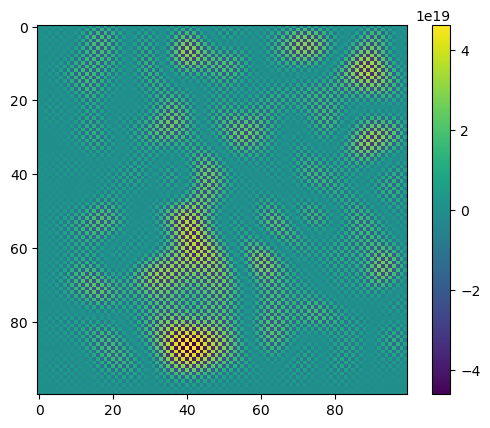

In [22]:
sd0 = np.load("parallel_out/ans_0_ai.npy")
sd1 = np.load("parallel_out/ans_1_ai.npy")

# print(sd0.shape,sd1.shape)
merged = np.concatenate([sd0,sd1], axis=1)

plt.imshow(merged)
plt.colorbar()

### Plot the error

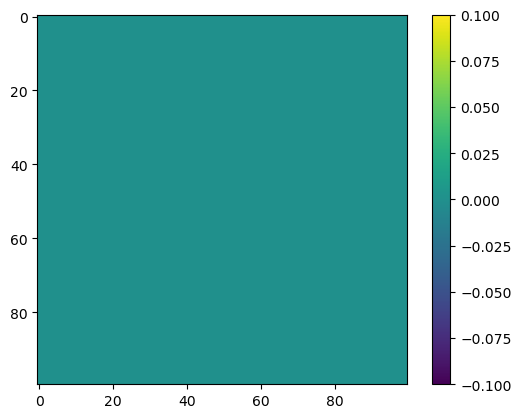

In [23]:
truth = problem_mesh.reshape(100,100)
err = np.abs(truth - merged)
plt.imshow(err)
plt.colorbar()

## Halo update with halo thickness > 1

(6, 6)


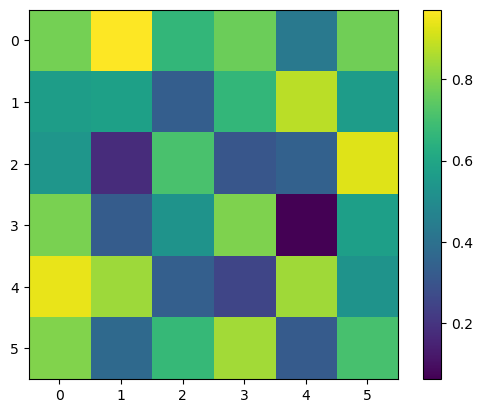

In [24]:
mult_mesh = np.array([[0.78261493, 0.97090189, 0.66327036, 0.76848217, 0.42800353,0.77528106],
                 [0.56767283, 0.57780701, 0.33225302, 0.66295884, 0.87718818,0.56417634],
                 [0.54046498, 0.17588775, 0.71082921, 0.30586232, 0.34552216,0.92550091],
                 [0.78670413, 0.32494218, 0.53005155, 0.79372642, 0.0620199,0.57615613],
                 [0.9406587, 0.83912257, 0.33540851, 0.25028467, 0.84222929,0.52955617],
                 [0.79936637, 0.374291, 0.6705437, 0.84339835, 0.32246901,0.70702548]])

print(mult_mesh.shape)
plt.imshow(mult_mesh)
plt.colorbar()

In [25]:
%%writefile decomposed_stencil_multi_halo.py

from time import perf_counter
from pprint import pprint
import numpy as np
from halos_exchange import HaloExchange

start = perf_counter()
h = HaloExchange(structured=True, halo_size=3, tensor_used=False,
                 double_precision=True, corner_exchanged=True) # here we try the halo size with 3

mesh = np.array([[0.78261493, 0.97090189, 0.66327036, 0.76848217, 0.42800353,0.77528106],
                 [0.56767283, 0.57780701, 0.33225302, 0.66295884, 0.87718818,0.56417634],
                 [0.54046498, 0.17588775, 0.71082921, 0.30586232, 0.34552216,0.92550091],
                 [0.78670413, 0.32494218, 0.53005155, 0.79372642, 0.0620199,0.57615613],
                 [0.9406587, 0.83912257, 0.33540851, 0.25028467, 0.84222929,0.52955617],
                 [0.79936637, 0.374291, 0.6705437, 0.84339835, 0.32246901,0.70702548]])
# pprint(mesh)
x, y, sub_domain = h.initialization(mesh,is_periodic=False,is_reordered=False)
print(sub_domain.shape)
print(sub_domain)

sub_domain = h.structured_halo_update_2D(sub_domain)
# print(sub_domain)

np.save('parallel_out/mult_halo_{}'.format(h.rank),sub_domain)

h.clear_cache()
end = perf_counter()
print(end - start)


Overwriting decomposed_stencil_multi_halo.py


In [26]:
mult_left_halo = np.load('parallel_out/mult_halo_0.npy')[3:-3,-3:]
mult_right_halo = np.load('parallel_out/mult_halo_1.npy')[3:-3,0:3]

# validation
print(np.allclose(mult_left_halo, mult_mesh[:,-3:]))
print(np.allclose(mult_right_halo, mult_mesh[:,0:3]))

True
True
